# Полезные статистики

In [1]:
!pip install tslearn -q
!pip install --upgrade pandas -q
!pip install seaborn -q

In [2]:
import numpy as np
import pandas as pd

import string
import random
import scipy

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from tqdm.notebook import tqdm


from tslearn.generators import random_walks
from itertools import cycle

import gc

YouDrive:  Среднее время поездки- 45 мин. Поездки совершают разные: Химки, Красногорск, Реутов, Щербинка. Но большинство поездок совершается в пределах Садового кольца.

Делимобиль: В центре делимобили не задерживаются на парковке более чем на 20-30 минут. В спальных районах скопление автомобилей наблюдается после 19:00 и там, машины проводят чаще всего всю ночь. Также, востребована услуга дальних поездок в режиме суточной аренды. Тогда пробег автомобиля увеличивается до 120 км. Напомним, что ограничение по включенному в тариф пробегу – 150км.

BelkaCar: Среднее время использования машины в летний период – 35 минут, в зимнее время, как правило, увеличивается до 45 минут. Большинство поездок совершается в пределах ТТК. 
Средний километраж поездки 15 км.

# Settings

In [3]:
car_info_size = 5_000
rider_info_size = 10_000
fix_info_size = 10_000
generate = False
num_months = 2.9

# Сгенерируем car_info

* `car_id` - int

------------

* `car_type` - str
* `fuel_type` - str
* `car_rating` - float
* `year_to_start` - int
* `riders` - int 

# Описание таргетов 

### Идеи для таргетов: https://edelweis-auto.ru/statyi/avtoelektrik-top-polomok.html
####### Еще варианты https://1gai.ru/baza-znaniy/sovety/521687-top-12-samyh-rasprostranennyh-problem-s-avtomobilem.html

Связать модели с поломками 
https://1gai.ru/baza-znaniy/525013-statistika-polomok-rejting-nadezhnosti-poderzhannyh-avtomobilej.html

* engine_check
Индикатор «Чек двигателя» -  Этот индикатор на приборке загорается, когда ЭБУ (электронный блок управления двигателем) 
обнаруживает в системе код ошибки в работе какой-либо системы. Например, это происходит, когда ошибку выдает датчик.

* engine_overheat
Перегрев двигателя - Наиболее частой причиной перегрева двигателя является утечка охлаждающей жидкости.
Например, чаще утечка антифриза связана с разгерметизацией радиатора охлаждения, поломкой водяной помпы или с повреждением расширительного бачка. Чтобы уменьшить риск перегрева мотора, нужно заранее менять радиатор и помпу. 

* engine_ignition
Пропуск зажигания — это явление, при котором по какой-то причине воспламенение не произошло, 
Машина ускоряется неровно, набор скорости ей дается тяжело. Неровный холостой ход. Вы можете почувствовать, что машина вибрирует. 
Дело в том, двигатель работает не сбалансированно из-за одного или нескольких неработающих цилиндров

* engine_fuel
Большой расход топлива - Когда двигатель работает эффективно, он сжигает топливо со скоростью, которая помогает эффективно 
расходовать топливо (экономия топлива). Однако некоторые детали топливной системы, такие как топливные фильтры, воздушные фильтры,
датчик массового расхода воздуха и кислородные датчики (лямба-зонд), со временем загрязняются и изнашиваются.

* electro_bug
Разряженный аккумулятор - Срок службы автомобильных аккумуляторов в среднем составляет 3-4 года, или 80 000-100 000 км. 
Батарея обычно стареет со временем, как и любой аккумулятор в вашем смартфоне. Чем чаще батарея проходит циклы разрядки/зарядки, тем быстрее она теряет способность поддерживать нормальный уровень заряда и определенное количество ампер.

* break_bug
Скрип тормозов - тормозная система подвержена износу в течение определенного времени. Тормоза жизненно важны для безопасной остановки.
Поэтому когда вы замечаете какие-либо признаки проблем, такие как визг, скрип или если, например, педаль тормоза стала мягкой, 

* wheel_shake
Дрожание рулевого колеса - Многочисленные проблемы могут вызвать дрожание/дребезжание рулевого колеса во время вождения.
Если это происходит сразу после запуска двигателя и начала вождения, причиной дрожания руля могут быть подшипники колес или поврежденные компоненты подвески. Если это происходит на более высоких скоростях, обычно это говорит о проблеме с балансировкой колес. 

* gear_stick
Неисправность автоматической коробки передач - При правильном обслуживании автоматическая коробка передач может без проблем работать более 300 000 км.
Современная автоматическая трансмиссия представляет собой гидравлическую систему, состоящую из нескольких сальников, прокладок и линий, которые могут быть повреждены, забиты мусором или протекать.
В большинстве случаев используемые сегодня автоматические коробки  передач при правильной эксплуатации и своевременном обслуживании могут потребовать капитальный ремонт при пробеге не ранее 150.000 километров.


engine_check engine_overheat engine_ignition fuel electro_bug break_bug wheel gear_stick

* `target_1` - int
* `target_2` - int

In [4]:
from sklearn.datasets import make_classification

def plot(df: pd.DataFrame, x1: str, x2: str, y: str, title: str = '', save: bool = False, figname='figure.png'):
    plt.figure(figsize=(14, 7))
    for class_cat in range(6):
        plt.scatter(x=df[df[y] == class_cat][x1], y=df[df[y] == class_cat][x2], label=f'y = {class_cat}')
    # plt.scatter(x=df[df[y] == 1][x1], y=df[df[y] == 1][x2], label='y = 1')
    plt.title(title, fontsize=20)
    plt.legend()
    if save:
        plt.savefig(figname, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()
    

In [5]:
# n_features = 8
# n_informative = 6
# X, y = make_classification(
#     n_classes = 6,
#     n_samples=generation_config_spb['n_samples'], 
#     n_features=n_features,
#     n_informative = n_informative,
#     # n_redundant=n_features - ,
#     n_clusters_per_class=6,
#     class_sep = -0.01,
#     # weights=[0.5],
#     random_state=42
# )

# df = pd.concat([pd.DataFrame(X), pd.Series(y)], axis=1)
# df.columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'y']

# plot(df=df, x1='x1', x2='x4', y='y', title='Dataset with 6 classes - Class imbalance (y = 0)')

In [6]:
generation_config = { 
                     'n_samples': int(car_info_size*2.2), 
                     'n_clusters':  8, 
                     'cluster_std' : 3.9,
                     'center_box' : (17, 19),
                     'n_features' : 8,
                     'random_state' : 75,
                     }


generation_config_spb = { 
                     'n_samples': int(car_info_size*0.85), 
                     'n_clusters':  8, 
                     'cluster_std' : 3.9,
                     'center_box' : (16, 18),
                     'n_features' : 8,
                     'random_state' : 75,
                     }

In [7]:
# импортируем второй датасет с двумя четко выраженными кластерами
from sklearn.datasets import make_blobs



target_classes ={
                  0 : 'gear_stick',
                  1 : 'wheel_shake',
                  2 : 'another_bug',
                  3 : 'electro_bug',
                  4 : 'engine_fuel',
                  5 : 'break_bug',
                  6 : 'engine_check',
                  7 : 'engine_overheat',
                  8 : 'engine_ignition',
                  # 0 : 'another_bug',
                  # 11 : 'another_bug'
                 }


# TODO Исправить ошибки в словаре ниже. Сделан на скорую руку.
car_model_conditions = {
    
  'Hyundai Solaris' : {'fuel_types' : 'petrol', 'car_type' : 'economy',  'year_to_start' : 2015,
                       'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18, 'rides_min' : 0, 
                       'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Kia Rio' : {'fuel_types' : 'petrol', 'car_type' : 'economy',  'year_to_start' : 2015,
               'rating_min': 1,  'aging_coef' : 0.5, 'age_min' : 18, 'rides_min' : 0, 
              'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Kia Rio X' : {'fuel_types' : 'petrol', 'car_type' : 'economy',  'year_to_start' : 2015,
                 'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Kia Rio X-line' : {'fuel_types' : 'petrol', 'car_type' : 'economy',  'year_to_start' : 2015,
                      'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                      'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Kia Sportage' : {'fuel_types' : 'petrol', 'car_type' : 'standart',  'year_to_start' : 2015,
                    'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                    'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Nissan Qashqai' : {'fuel_types' : 'petrol', 'car_type' : 'standart',  'year_to_start' : 2015,
                      'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                      'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Renault Kaptur' : {'fuel_types' : 'petrol', 'car_type' : 'standart',  'year_to_start' : 2015,
                      'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                      'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Renault Sandero' : {'fuel_types' : 'petrol', 'car_type' : 'standart',  'year_to_start' : 2015,
                       'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                       'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Skoda Rapid' : {'fuel_types' : 'petrol',  'car_type' : 'economy', 'year_to_start' : 2017,
                   'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                   'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Smart ForFour' : {'fuel_types' : 'petrol', 'car_type' : 'economy',  'year_to_start' : 2017,
                     'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                     'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Smart ForTwo' : {'fuel_types' : 'petrol', 'car_type' : 'economy',  'year_to_start' : 2017,
                    'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                    'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Smart Coupe' : {'fuel_types' : 'petrol', 'car_type' : 'economy',  'year_to_start' : 2017,
                   'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                   'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'VW Polo' :   {'fuel_types' : 'petrol', 'car_type' : 'economy',  'year_to_start' : 2015,
                 'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'VW Polo VI' : {'fuel_types' : 'petrol', 'car_type' : 'economy',  'year_to_start' : 2015,
                  'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                  'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},

  'BMW 320i' : {'fuel_types' : 'petrol', 'car_type' : 'business',  'year_to_start' : 2017,
                'rating_min': 7, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Fiat 500' : {'fuel_types' : 'petrol', 'car_type' : 'business',  'year_to_start' : 2015,
                'rating_min': 7, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Mini Cooper' : {'fuel_types' : 'petrol', 'car_type' : 'business',  'year_to_start' : 2015, 
                   'rating_min': 7, 'aging_coef' : 0.7, 'age_min' : 18,  'rides_min' : 50, 
                'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'MINI CooperSE' : {'fuel_types' : 'electro', 'car_type' : 'business',  'year_to_start' : 2015,
                     'rating_min': 7, 'aging_coef' : 0.8, 'age_min' : 21,   'rides_min' : 100, 
                'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Mercedes-Benz E200' : {'fuel_types' : 'petrol', 'car_type' : 'business',  'year_to_start' : 2015,
                          'rating_min': 7.5, 'aging_coef' : 0.7, 'age_min' : 21,  'rides_min' : 100, 
                'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Mercedes-Benz GLC' : {'fuel_types' : 'petrol', 'car_type' : 'business',  'year_to_start' : 2015,
                         'rating_min': 8, 'aging_coef' : 0.7, 'age_min' : 21,  'rides_min' : 150, 
                'year_to_work' : ['2016', '2017', '2018', '2019', '2020', '2021']},

  'Audi A3' : {'fuel_types' : 'petrol', 'car_type' : 'premium',  'year_to_start' : 2017,
               'rating_min': 7, 'aging_coef' : 0.69, 'age_min' : 21,  'rides_min' : 150, 
               'year_to_work' : ['2018', '2019', '2020', '2021']},
    
  'Audi A4' : {'fuel_types' : 'petrol', 'car_type' : 'premium',  'year_to_start' : 2017,
               'rating_min': 7, 'aging_coef' : 0.7, 'age_min' : 21,  'rides_min' : 300, 
               'year_to_work' : ['2018', '2019', '2020', '2021']},
    
  'Audi Q3' : {'fuel_types' : 'petrol', 'car_type' : 'premium',  'year_to_start' : 2017,
               'rating_min': 7, 'aging_coef' : 0.7, 'age_min' : 21,  'rides_min' : 300, 
               'year_to_work' : [ '2018', '2019', '2020', '2021']},
    
  'VW Tiguan' : {'fuel_types' : 'petrol', 'car_type' : 'economy',  'year_to_start' : 2017,
                 'rating_min': 1, 'aging_coef' : 0.8, 'age_min' : 21,  'rides_min' : 100, 
               'year_to_work' : ['2018', '2019', '2020', '2021']},

  'Tesla Model 3' : {'fuel_types' : 'electro', 'car_type' : 'premium',  'year_to_start' : 2017,
                'rating_min': 9, 'aging_coef' : 1, 'age_min' : 23,  'rides_min' : 400, 
                'year_to_work' : ['2018', '2019', '2020', '2021']},
    
  'Volkswagen ID.4 ' : {'fuel_types' : 'electro', 'car_type' : 'premium',  'year_to_start' : 2017,
                'rating_min': 8.9, 'aging_coef' : 0.8, 'age_min' : 21,  'rides_min' : 200, 
                'year_to_work' : ['2018', '2019', '2020', '2021']},
}

# car_model_conditions 


In [4]:
def add_model_pattern(x):
    target = x.target_2
    
    if target in ['wheel_shake'] and x.car_type in ['business', 'premium', 'standart'] and x.fuel_type not in ['electro']:
            target = np.random.choice(['gear_stick', 'another_bug', 'engine_fuel', 'break_bug', 'engine_check', 'engine_overheat', 'engine_ignition'])
    
    elif target in ['wheel_shake'] and x.car_type in ['business', 'premium', 'standart']:
            target = np.random.choice(['gear_stick', 'another_bug', 'engine_fuel', 'break_bug', 'engine_check', 'engine_overheat', 'electro_bug'])
    
    
    return target

In [9]:
if generate:
        
#     # Это будет Питер
#     X_blobs_spb, y_blobs_spb = make_blobs(n_samples = generation_config_spb['n_samples'],
#                                   centers = generation_config_spb['n_clusters'],
#                                   cluster_std = generation_config_spb['cluster_std'],
#                                   center_box = generation_config_spb['center_box'],
#                                   n_features = generation_config_spb['n_features'],
#                                   random_state = generation_config_spb['random_state'],
#                              )
#     # print(y_blobs_spb)
#     y_blobs_spb+=1
#     # print(y_blobs_spb)

#     # Это будет Москва
#     X_blobs_msk, y_blobs_msk = make_blobs(n_samples = generation_config['n_samples'],
#                                   centers = generation_config['n_clusters'],
#                                   cluster_std = generation_config['cluster_std'],
#                                   center_box = generation_config['center_box'],
#                                   n_features = generation_config['n_features'],
#                                   random_state = generation_config['random_state'],
#                                  )

#     # print(y_blobs_msk)
#     y_blobs_msk-=1
#     # print(y_blobs_msk)

#     X_blobs = np.concatenate((X_blobs_msk, X_blobs_spb), axis=0)
#     y_blobs = np.concatenate((y_blobs_msk, y_blobs_spb), axis=0)

#     cities = np.concatenate((np.array([0]*y_blobs_msk.shape[0]), np.array([1]*y_blobs_spb.shape[0])), axis=0)

#     print(X_blobs.shape)
#     plt.figure(figsize=(12,9))
#     plt.scatter(X_blobs[:,0], X_blobs[:,1], c=y_blobs, cmap ='plasma')
#     plt.legend(y_blobs)
#     plt.show()


    n_informative = 6
    X, y = make_classification(
        n_classes = 9,
        n_samples=generation_config_spb['n_samples'], 
        n_features=generation_config_spb['n_features'],
        n_informative = n_informative,
        # n_redundant=n_features - ,
        n_clusters_per_class=6,
        class_sep = -0.01,
        # weights=[0.5],
        random_state=42
    )

    df = pd.concat([pd.DataFrame(X), pd.Series(y)], axis=1)
    cols = ['car_type', 'fuel_type', 'car_rating', 'year_to_start', 'riders', 'car_id', 'model', 'target_1', 'target_2']
    df.columns = cols
    
    # Построим примеры
    plot(df=df, x1='car_type', x2='car_rating', y='target_2', title='Dataset with 6 classes - Class imbalance (y = 0)')

    
    # df = pd.DataFrame(X_blobs, columns = cols)
    # df['main_city'] = cities
    
    
    df['target_1'] = df['target_1'].clip(lower = 0, upper = df['target_1'].max()*0.8).astype(int)


    # df['target_2'] = y_blobs

    change_target = lambda x : target_classes.get(x, x)
    df['target_2'] = df['target_2'].apply(change_target)


    hash_f = lambda x: '{}{}{}'.format(random.choice(string.ascii_letters), str(hash(x))[:8], random.choice(string.ascii_letters), random.choice(string.ascii_letters))
    df['car_id'] = df[['riders', 'year_to_start', 'car_rating', 'target_2', 'car_id']].sum(axis=1).map(hash_f).astype(str)


    models = list(car_model_conditions.keys())
    p = [1/car_model_conditions[m]['rating_min'] for m in car_model_conditions.keys()]
    p = [i/sum(p) for i in p]
    get_models = lambda x: np.random.choice(models, p = p)
    
    df['year_to_start'] += np.random.random(size=df.shape[0])/3
    df['riders'] += np.random.random(size=df.shape[0])/3
    df['model'] += np.random.random(size=df.shape[0])/3
    df['model'] = df['model'].apply(get_models)
    # df['model'] = pd.cut(df['model'], len(car_model_conditions.keys()), labels = car_model_conditions.keys()).astype(str)

    # fuel_types = ['diesel', 'gas', 'petrol', 'electro']
    # df['fuel_type'] = pd.cut(df['fuel_type'], len(fuel_types), labels = fuel_types)

    get_val = lambda x: car_model_conditions[x]['fuel_types']
    df['fuel_type'] = df['model'].apply(get_val)

    # car_types = ['luxury', 'standart_1','standart_2', 'sport', 'economy',  'business',]
    # df['car_type'] = pd.cut(df['car_type'], len(car_types), labels = car_types)

    get_val = lambda x: car_model_conditions[x]['car_type']
    df['car_type'] = df['model'].apply(get_val)


    cat_type_dict = {'standart_1' : 'standart', 'standart_2' : 'standart'}
    cat_type_func = lambda x: cat_type_dict.get(x, x)
    df['car_type'] = df['car_type'].apply(cat_type_func)

    df['car_rating'] = df['car_rating'] + np.random.random(size=df.shape[0])/3
    df['car_rating'] += df['car_rating'].min()
    df['car_rating'] = df['car_rating'] // (df['car_rating'].max()*0.02) / 50

    get_val = lambda x: np.random.choice(car_model_conditions[x]['year_to_work'])
    df['year_to_work'] = df['model'].apply(get_val).astype(int)
    df['year_to_work'] -= np.random.choice([-1, 0, 1], size = df.shape[0])

    df['target_2'] = df.apply(add_model_pattern, axis=1)
    
    get_val = lambda x: car_model_conditions[x]['year_to_start'] - np.random.choice([0, 1, 2, 3, 4], p = [0.3, 0.2, 0.2, 0.15, 0.15])
    df['year_to_start'] = df['model'].apply(get_val)

    # years_list = [2017, 2018, 2020, 2019, 2021, 2022]
    # df['year_to_start'] = pd.cut(df['year_to_start'], len(years_list), labels = years_list).astype(int)

    df['riders'] = df['riders'] - np.random.random(size=df.shape[0])/4
    df['riders'] = ((df['year_to_start'] - 2015)*365*24*2 + 3_000*df['riders'])
    df['riders'] = abs(df['riders'] - df['riders'].mean())
    df['riders'] = df['riders'].clip(lower = 1).astype(int)

    print(df['car_id'].str.len().min(), df['car_id'].str.len().max(),  df['car_id'].nunique(), df.shape[0])
    print('car_info', df.shape, df['car_id'].nunique())

    df.hist(figsize = (20, 10), bins=45)

    car_info = df

    car_info.to_csv('../data/tmp_car_info.csv', index=False)

    df.describe()
    gc.collect()

    # TODO добавить зависимость таргетов
    
else:
    
    car_info = pd.read_csv('../data/tmp_car_info.csv')

In [10]:
# sns.displot(data = df, x = 'riders', y = 'car_rating', hue = 'main_city', aspect=3);

In [11]:
# # TODO Добавить дисбаланс классов
# df['target_2'].value_counts()
# df['target_2'].unique()  
# df['year_to_work'].value_counts()

In [12]:
# car_info['car_type'].value_counts() #.head()
# car_info.columns

In [13]:
# df['model'].value_counts()

In [14]:
# car_info.head()

# Сгенерируем rider_info

* `user_id` - ID пользователя

-----------

* `first_ride_date` - дата первой поездки

-----------
* `sex` - пол
* `age` - возвраст (средний возраст мужчин - 48 лет, женщин - 45)
* `user_rating` - рейтинг
* `user_rides` - количество поездок
* `user_time_accident` - количество инцидентов

In [15]:
# Штрафы
# Не следует забывать о том, что в каршеринге действуют строгие правила, нарушение которых может повлечь за собой штрафные санкции. К одним из них относятся:

# курение в салоне (2000) руб;
# загрязнение салона (2000 руб);
# передача руля третьему лицу (100 000 руб);
# перевозка животных без специальной переноски (2000 руб);
# дрифтинг (100 000 руб);
# парковка на газоне/тротуаре (100 000 руб);

rider_info


,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
0,27,9.0,865,18,m17437965Y,1,2019-4-2
1,46,7.9,2116,10,k12362316g,0,2021-11-19
2,59,8.1,947,5,P11098715I,0,2021-1-15
3,37,6.9,18,52,F12618125f,0,2019-11-20
4,39,8.3,428,7,F14375829N,0,2019-7-23


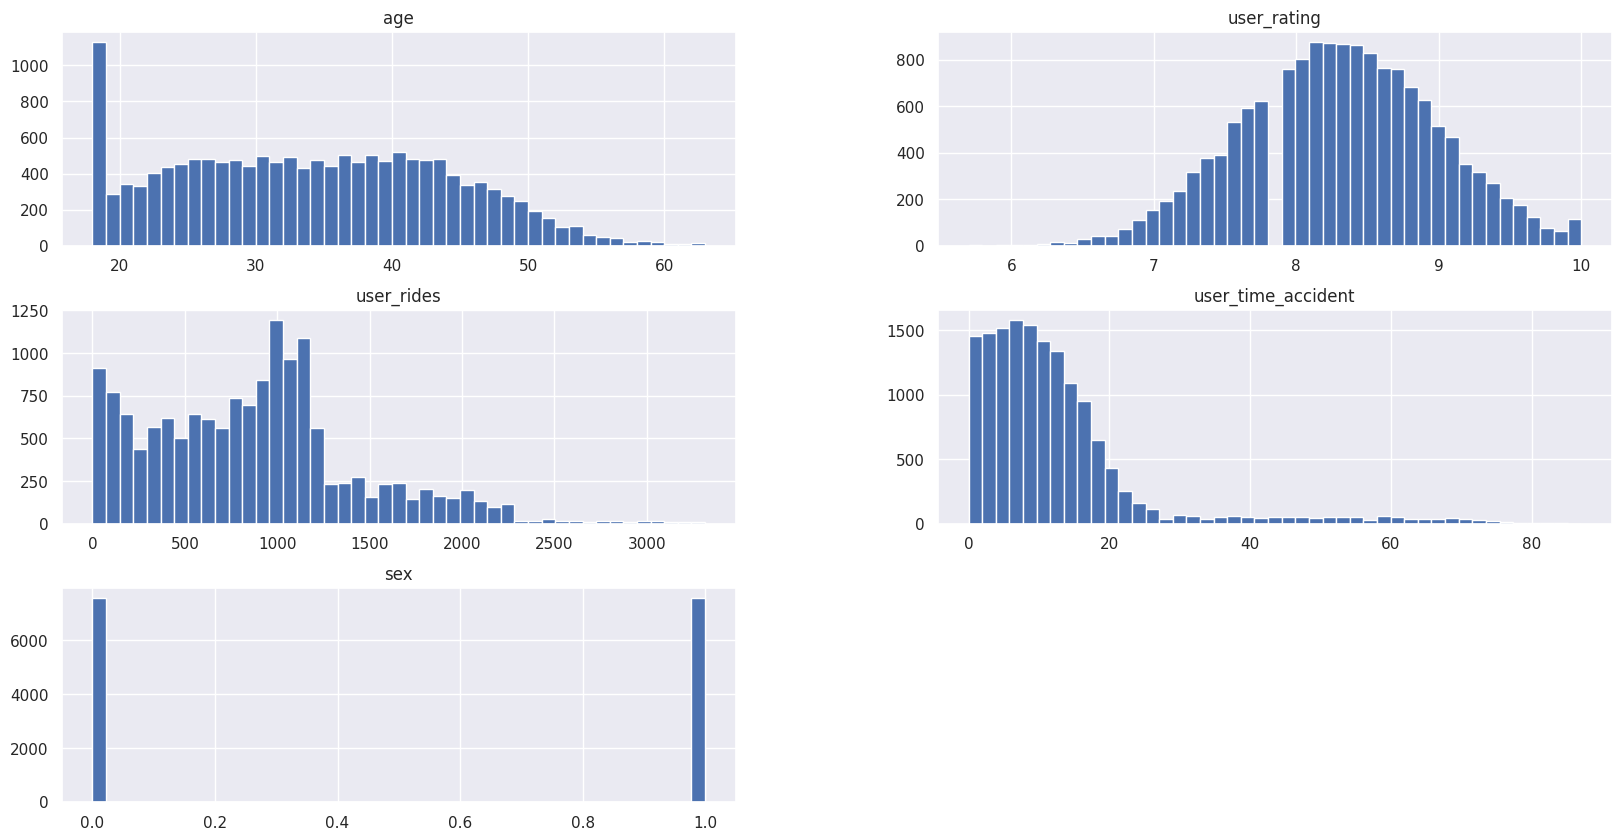

In [16]:
generation_config = { 
                     'n_samples': 15_153, 
                     'n_clusters':  2, 
                     'n_features' : 8,
                     'cluster_std' : 1.5,
                     'center_box' : (13, 17),
                     'random_state' : 7575,
                     }


if generate:    

    X_blobs, y_blobs = make_blobs(n_samples = generation_config['n_samples'],
                                  centers = generation_config['n_clusters'],
                                  cluster_std = generation_config['cluster_std'],
                                  center_box = generation_config['center_box'],
                                  n_features = generation_config['n_features'],
                                  random_state = generation_config['random_state'],
                                 )


    print(X_blobs.shape)
    plt.figure(figsize=(6, 6))
    plt.scatter(X_blobs[:,0], X_blobs[:,1], c=y_blobs, cmap ='Set3')
    plt.legend(y_blobs)
    plt.show()


    cols = ['year', 'month','day', 'age', 'user_rating', 'user_rides', 'user_time_accident', 'user_id']
    df = pd.DataFrame(X_blobs, columns = cols)
    df['sex'] = y_blobs

    hash_f = lambda x: '{}{}{}'.format(random.choice(string.ascii_letters), str(hash(x))[:8], random.choice(string.ascii_letters))
    df['user_id'] = df[['year', 'month','day', 'age', 'user_rating', 'user_rides', 'user_id']].sum(axis=1).map(hash_f).astype(str)


    df.describe()

    df['age'] = df['age'] // (df['age'].max()*0.01) // 1
    df['age'] = df['age'] - 34
    df['age'] = df['age'].clip(lower = 18, upper = df['age'].max()*0.98).astype(int)

    df['user_rating'] += np.random.random(size = df.shape[0])
    df['user_rating'] = (df['user_rating'] // (df['user_rating'].max()*0.01)) / 10
    df['user_rating'] += 1
    df['user_rating'] = df['user_rating'].clip(lower = 0, upper = 10)
        
    
    years_list = [2017, 2018, 2020, 2019, 2021, 2022]
    df['year'] = pd.cut(df['year'], len(years_list), labels = years_list).astype(int)
    df['month'] = pd.qcut(df['month'], q = 12, labels = range(1, 13)).astype(int)
    df['day'] = pd.qcut(df['day'], q = 30, labels = range(1, 31)).astype(int)

    df['user_rides'] =((df['year'] - 2017)*365*24*1.2 + \
                   df['month']*30*24*1.6 + \
                   df['day']*24*1.8 + \
                   df['user_rides'] + df['user_rating']*5
                      ).astype(int)
    
    df['user_rides'] = abs(30*(df['user_rides'] - df['user_rides'].mean()) / 300 ).astype(int)

    df['user_time_accident'] = (df['user_time_accident']*7 + df['user_rides'] / 14_000)
    
    df['user_time_accident'] = df['user_time_accident'] / (df['user_rating'] / 4 )
    
    df['user_time_accident'] = abs(df['user_time_accident'] - df['user_time_accident'].mean() - df['user_rating']) 
    
    df['user_time_accident'] = df['user_time_accident'].clip(lower = 0, upper = df['user_time_accident'].max()*0.9).astype(int)

    tmp = np.random.random(size = df.shape[0]) > 0.90
    df['eng_check'] = tmp
    df['user_time_accident'] += (tmp)*(np.random.random(size = df.shape[0])*60 + np.random.randint(10)).astype(int)
    
    df['first_ride_date'] = df['year'].astype(str) + "-" +  df['month'].astype(str) + "-" +  df['day'].astype(str)
    df.drop(['year', 'month', 'day'], axis=1, inplace=True)

    print(df['user_id'].str.len().min(), df['user_id'].str.len().max(),  df['user_id'].nunique(), df.shape[0])

    
    rider_info = df

    rider_info.drop('eng_check', axis=1).to_csv('../data/tmp_driver_info.csv', index=False)
    
else:
    
    rider_info = pd.read_csv('../data/tmp_driver_info.csv')
    

rider_info.hist(figsize = (20, 10), bins=45)
print('rider_info')
gc.collect()
rider_info.head()
    

In [17]:
# tmp = (np.random.random(size = 20) > 0.90)*(np.random.random(size = 20)*30).astype(int)

# fix_info

* `car_id`
* `worker_id`
* `five_previous_user_id`
----------------
* `time`
* `work_type`
* `destroy_degree`
* `work_duration`

In [18]:
# TODO пофиксить вот это
# 'Recall:class=6': # 'engine_ignition' 
# 'Recall:class=5': # engine_check
# 'Recall:class=3': # gear_stick
# 'Recall:class=8': # electro_bug

def fix_pattern_1(x):  # Закладываем инфу в ремонт
    
    target = x.target_2
    work_duration = x.work_duration
    
    if target in ['electro_bug']:
        work_duration = min(48, x.work_duration)
            
    return work_duration 

def fix_pattern_2(x):  # Закладываем инфу в rating
    
    target = x.target_2
    destroy_degree = x.destroy_degree
    
    if target in ['engine_ignition', 'engine_check']:
        destroy_degree = min(5, x.destroy_degree)
        
        
    return destroy_degree 

def fix_pattern_3(x): # Заложим паттерн на класс engine_overheat wheel_shake
    target = x.target_2
    work_type = x.work_type
    
    # 'Recall:class=7': 0.31666666666666665, wheel_shake
# 'Recall:class=4': 0.39344262295081966, engine_fuel
# 'Recall:class=3': 0.3114754098360656, gear_stick
    
    if target in ['gear_stick', 'engine_fuel']:
        if x.work_type in ['oil_change']:
            if np.random.random() > 0.1:
                work_type = np.random.choice(['refuel_reparking', 'refuel', 'reparking', 'repair', 'refuel_check'])
    
    if target in ['engine_overheat', 'wheel_shake']:
        if x.work_type in ['oil_change', 'refuel_check', 'repair']:
            if np.random.random() > 0.1:
                work_type = np.random.choice(['refuel_reparking', 'refuel', 'reparking'])
    
    return work_type    
        
        

tqdm.pandas()

In [19]:
if generate:    

    generation_config = { 
                     'n_samples': int(((10_000*365*4 / 50)/ 10)*0.5)*10, 
                # машины*дни*годы / рабочие / скорость обслуживания * необходимая частота обслуживания 
                     'n_clusters':  2, 
                     'n_features' : 10,
                     'cluster_std' : 1.5,
                     'center_box' : (10, 15),
                     'random_state' : 7575,
                     }

    # Это будет Питер
    X_blobs, y_blobs = make_blobs(n_samples = generation_config['n_samples'],
                              centers = generation_config['n_clusters'],
                              cluster_std = generation_config['cluster_std'],
                              center_box = generation_config['center_box'],
                              n_features = generation_config['n_features'],
                              random_state = generation_config['random_state'],
                             )

    print(X_blobs.shape)
    plt.figure(figsize=(6, 6))
    plt.scatter(X_blobs[:,0], X_blobs[:,1], c=y_blobs, cmap ='Set3')
    plt.legend(y_blobs)
    plt.show()

    cols = ['year', 'month', 'day', 'hour', 'mins', 'work_type', 'destroy_degree', 'work_duration', 'car_id', 'worker_id']
    df = pd.DataFrame(X_blobs, columns = cols)
    df['sex'] = y_blobs

    years_list = ['refuel_reparking', 'refuel', 'reparking', 'repair', 'refuel_check', 'oil_change']
    df['work_type'] = pd.cut(df['work_type'], len(years_list), labels = years_list)

    years_list = [2017, 2018, 2020, 2019, 2021, 2022]
    df['year'] = pd.cut(df['year'], len(years_list), labels = years_list).astype(int)
    df['month'] = pd.qcut(df['month'], q = 12, labels = range(1, 13)).astype(int)
    df['day'] = pd.qcut(df['day'], q = 30, labels = range(1, 31)).astype(int)

    df['hour'] = pd.qcut(df['hour'], q = 24, labels = range(24)).astype(int)
    df['mins'] = pd.qcut(df['mins'], q = 60, labels = range(60)).astype(int)

    df['destroy_degree'] += np.random.random(size = len(df))*10 + np.random.random(size = len(df))*25 + np.random.random(size = len(df))*55
    df['destroy_degree'] += np.random.random(size = len(df))*10 + np.random.random(size = len(df))*25 + np.random.random(size = len(df))*55
    df['destroy_degree'] += np.random.random(size = len(df))*10 + np.random.random(size = len(df))*25 + np.random.random(size = len(df))*55
    
    df['destroy_degree'] = df['destroy_degree'] // (df['destroy_degree'].max()*0.01) / 10
    
    df['destroy_degree'] = df['destroy_degree'].values*df['work_type'].isin(['repair'])
    
    df['destroy_degree'] += np.random.choice([0, 1], size = df.shape[0], p = [0.92, 0.08])*np.random.randint(8, 11, size = df.shape[0])
    df['destroy_degree'] = df['destroy_degree'].clip(lower = 1, upper = 10)
    
    df['work_duration'] = df['work_duration'] + df['destroy_degree']*10 + abs(df['hour'] - 14)

    df['work_duration'] = abs(df['work_duration'] - df['work_duration'].mean()).astype(int)
    df['work_duration'] = df['work_duration'].clip(lower = 1)

    names, fios = 'BCDFGHJKLMNOPRSTVWXYZ', 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    hash_f = lambda x: '{}{}'.format(random.choice(fios), random.choice(names))
    df['worker_id'] = df[['year']].sum(axis=1).map(hash_f).astype(str)

    
    cars_ids = car_info['car_id'].unique().tolist()
    cycler = cycle(cars_ids)
    df['car_id'] = df['sex'].apply(lambda x: next(cycler))
    # wheel_shake
    
    # TODO завимость от таргета
    cols = ['car_id', 'model', 'car_type', 'target_2']
    df = df.merge(car_info[cols], on = 'car_id', how = 'left')
    
    df['work_duration'] = df.progress_apply(fix_pattern_1, axis=1)
    df['destroy_degree'] = df.progress_apply(fix_pattern_2, axis=1)
    
    # cars_ids = car_info['car_id'].unique().tolist()
    # hash_f = lambda x: '{}'.format(random.choice(cars_ids))
    # df['car_id'] = df[['car_id']].sum(axis=1).map(hash_f).astype(str)

    df['fix_date'] = df['year'].astype(str) + "-" +  df['month'].astype(str) + "-" +  df['day'].astype(str)
    df['fix_date'] = df['fix_date'].astype(str) + " " +  df['hour'].astype(str) + ":" +  df['mins'].astype(str)

    df.drop(['year', 'month', 'day', 'hour', 'mins', 'sex', 'model', 'car_type', 'target_2'], axis=1, inplace=True, errors = 'ignore')

    print('worker_id', df['worker_id'].nunique(), df.shape[0])
    print('car_id',    df['car_id'].nunique(), df.shape[0])

    
    df.hist(figsize = (20, 5), bins=30)
    print('fix_info')
    df.head()

    cols_order = ['car_id', 'worker_id', 'fix_date', 'work_type', 'destroy_degree', 'work_duration']
    fix_info = df[cols_order]

    fix_info.to_csv('../data/fix_info.csv', index=False)

    df.describe()
    df.info()
    
else:
    fix_info = pd.read_csv('../data/fix_info.csv')
    df = fix_info
    
fix_info.head()

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
0,Z16209094a,PJ,2020-6-20 2:14,reparking,1.0,21
1,J-1559355B,ZJ,2020-2-9 20:25,repair,10.0,48
2,I-1144396V,KL,2019-8-24 7:1,reparking,1.0,27
3,i14360916r,CP,2019-8-10 9:29,reparking,1.0,28
4,q13819346b,VZ,2020-11-12 5:22,refuel_check,1.0,22


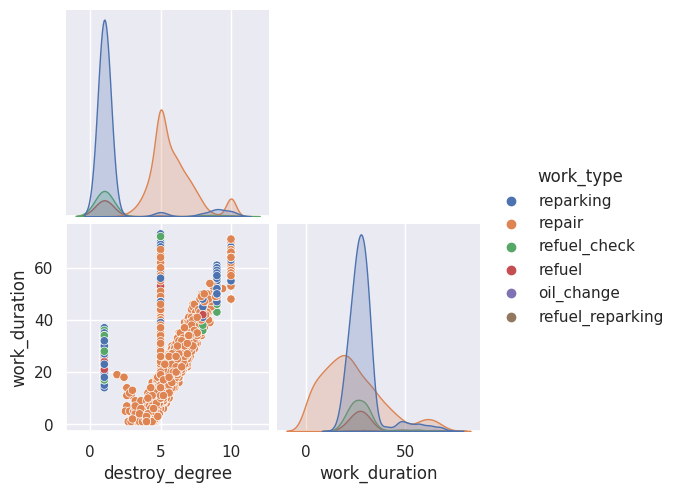

In [20]:
ids_car = fix_info['car_id'].unique()[:100]
tmp = fix_info[fix_info['car_id'].isin(ids_car)]
sns.pairplot(data = tmp, hue = 'work_type', corner=True);

In [21]:
# df.info()
# df.groupby('work_type')['destroy_degree'].agg(['sum', 'count'])

In [22]:
# df.groupby(['car_id', 'work_type'], as_index=False)['destroy_degree'].count()['destroy_degree']#.min()

In [23]:
# df.destroy_degree.value_counts()


In [24]:
df.head()

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
0,Z16209094a,PJ,2020-6-20 2:14,reparking,1.0,21
1,J-1559355B,ZJ,2020-2-9 20:25,repair,10.0,48
2,I-1144396V,KL,2019-8-24 7:1,reparking,1.0,27
3,i14360916r,CP,2019-8-10 9:29,reparking,1.0,28
4,q13819346b,VZ,2020-11-12 5:22,refuel_check,1.0,22


<AxesSubplot: >

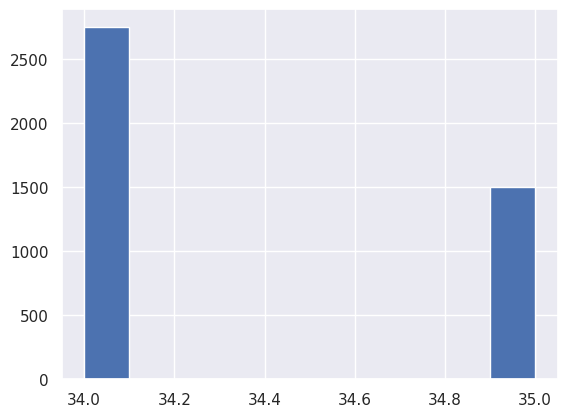

In [25]:
# assert False
df['car_id'].value_counts().hist()

In [26]:
# TODO дозаправка и перегонка происходят чаще ночью


In [27]:
# df = pd.DataFrame(X_blobs)
# df.describe()

# Генерируем поездки - rides_info

In [28]:
# n_1 = 140 + np.random.randint(30)
# n_2 = 180 - n_1
# part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu=1, std=1).reshape(1, -1)[0]
# part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu=-1, std=1).reshape(1, -1)[0] + max(part_1)
# rw = np.concatenate((part_1, part_2))

# plt.plot(rw)

In [29]:
# n_1 = 120 + np.random.randint(20)
# n_2 = 180 - n_1
# part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu=0, std=1).reshape(1, -1)[0]
# part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu=-1, std=1).reshape(1, -1)[0] + max(part_1) + 20
# rw = np.concatenate((part_1, part_2))
# print(n_1)
# plt.plot(rw)

In [30]:
# n_1 = 100 + np.random.randint(40)
# n_2 = 180 - n_1
# part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu=0, std=1).reshape(1, -1)[0]
# part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu=-1, std=1).reshape(1, -1)[0] + max(part_1)

# out_1= np.random.randint(len(part_2))
# part_2[out_1]-=50
# out_2 = np.random.randint(len(part_2))
# part_2[out_2]-=50

# feature = n_1 + max(out_1, out_2)
# rw = np.concatenate((part_1, part_2))

# plt.plot(rw)

In [31]:
# n_1 = 70 + np.random.randint(70)
# n_2 = 180 - n_1
# part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu = 0, std=1).reshape(1, -1)[0]
# part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu = 0, std=1).reshape(1, -1)[0] + min(part_1)

# out_s1 = np.random.randint(60, size = len(part_2))
# out_s2 = np.random.randint(60, size = len(part_2))
# part_2 -= out_s1
# part_2 += out_s2
# feature = n_1 
# rw = np.concatenate((part_2, part_1))


# print(feature)
# plt.plot(rw)

In [5]:
target_ratios = {
                        'gear_stick'  : 0.7,
                        'wheel_shake' : 0.7,
                        'another_bug'   : 0.8,
                        'electro_bug'   : 0.8,
                        'engine_fuel'   : 0.8,
                        'break_bug'       : 0.9,
                        'engine_check'    : 0.9,
                        'engine_overheat' : 0.9,
                        'engine_ignition' : 0.9 
}

car_types_ratio_bies = {'premium'  : 0.90,   
                        'business' : 0.80,
                        'standart' : 0.50,      
                        'economy'  : 0.01
                     }

car_types_ratio_bies

{'business': 0.8, 'standart': 0.5, 'premium': 0.9, 'economy': 0}

In [32]:
def make_crew(x):
    if x < 0: return abs(x)
    else: return x + 3*np.random.randint(5)*np.random.randint(2)*np.random.random()
    
    
def get_user_by_car(x):
    
    '''
    Предлагаемые машины пользователям в зависит от самого пользователя.
    Теслы предлгаются только самым "хорошим"
    Бехи и спорткары тоже только самым хорошим
    Электрокары можно получить проще
    
    '''
    car_id = x.car_id
    target = x.target_2
    # TODO rider_info eng_check
    
    car_model = car_info[car_info['car_id'] == car_id]['model'].values[0]     
    car_tmp = car_model_conditions[car_model]
    
    if target in ['engine_fuel', 'wheel_shake', 'another_bug', 'engine_check']:
        if np.random.random() > 0.5:
            # В случае этих причин иногда возвращать людей с выбросами
            user_ids = rider_info[(rider_info['user_rating'] >= car_tmp['rating_min'])
                            &(rider_info['age'] >= car_tmp['age_min'])
                            &(rider_info['eng_check'] == True)
                            &(rider_info['user_rides'] >= car_tmp['rides_min'])
                            &(rider_info['user_time_accident'] >= np.random.choice([5, 10, 20]) )
                                 ]['user_id'].unique()
        else:
            user_ids = rider_info[(rider_info['user_rating'] >= car_tmp['rating_min'])
                            &(rider_info['age'] >= car_tmp['age_min'])
                            &(rider_info['eng_check'] == False)
                            &(rider_info['user_rides'] >= car_tmp['rides_min'])
                            &(rider_info['user_time_accident'] <= np.random.choice([10, 40], p = [0.1, 0.9]) )
                                 ]['user_id'].unique()
            
    elif target in ['engine_overheat', 'gear_stick']: 
        if np.random.random() > 0.5:
            # В случае этих причин иногда возвращать людей с выбросами
            user_ids = rider_info[(rider_info['user_rating'] >= car_tmp['rating_min'])
                            &(rider_info['age'] >= car_tmp['age_min'])
                            &(rider_info['user_rating'] <= max(8, car_tmp['rating_min']))
                            &(rider_info['eng_check'] == False)
                            &(rider_info['user_rides'] >= car_tmp['rides_min'])
                            &(rider_info['user_time_accident'] >= np.random.choice([3, 5, 7]) )
                                 ]['user_id'].unique() 
        else:
            user_ids = rider_info[(rider_info['user_rating'] >= car_tmp['rating_min'])
                            &(rider_info['age'] >= car_tmp['age_min'])
                            &(rider_info['eng_check'] == False)
                            &(rider_info['user_rides'] >= car_tmp['rides_min'])
                            # &(rider_info['user_time_accident'] >= 5)
                                 ]['user_id'].unique() 
            
            
            
    else:
        user_ids = rider_info[(rider_info['user_rating'] >= car_tmp['rating_min'])
                        &(rider_info['age'] >= car_tmp['age_min'])
                        &(rider_info['eng_check'] == False)
                        &(rider_info['user_rides'] >= car_tmp['rides_min'])
                        &(rider_info['user_time_accident'] <= np.random.choice([13, 25, 27, 40], p = [0.6, 0.2, 0.15, 0.05]))
                             ]['user_id'].unique() 

    if len(user_ids) == 0: 
        user_ids = rider_info[(rider_info['user_rating'] >= min(car_tmp['rating_min'], np.random.choice([4, 5, 7, 6])))
                &(rider_info['age'] >= car_tmp['age_min'])
                &(rider_info['eng_check'] == False)
                &(rider_info['user_rides'] >= car_tmp['rides_min'])
                &(rider_info['user_time_accident'] <= np.random.choice([13, 25, 27, 40], p = [0.6, 0.2, 0.15, 0.05]) )
                             ]['user_id'].unique()
        
        print(car_tmp, car_model)
        print(car_id, '--------', target)
        assert len(user_ids) != 0
        return random.choice(user_ids)
    else:
        return random.choice(user_ids)
     
    

def generate_features(X):
    
    car_id = X.car_id
    user_id = X.user_id

    ride_cost = X.ride_cost
    ride_duration = X.ride_duration
    
    distance = X.distance
    stop_times = abs(X.stop_times)
    refueling = X.refueling*0
    speed_avg = X.speed_avg
    
    # Car info
    # TODO исправить 
#     tmp = car_info[car_info['car_id'] == car_id]
    
    car_type = X.car_type #tmp['car_type'].values[0]
    fuel_type = X.fuel_type # tmp['fuel_type'].values[0]
    # car_rating = X.car_rating # tmp['car_rating'].values[0]
#     year_to_start = tmp['year_to_start']
#     riders = tmp['riders']
#     # main_city = tmp['main_city']
    
    car_shift = car_type_shift[car_type]
    
    # Driver info 
#     user_time_accident = driver_info[driver_info['user_id'] == user_id]['user_time_accident']
#     user_rides = driver_info[driver_info['user_id'] == user_id]['user_rides']
#     user_rating = driver_info[driver_info['user_id'] == user_id]['user_rating']
#     age = driver_info[driver_info['user_id'] == user_id]['age']
    
    
    if fuel_type == 'electro':
        refueling = refueling*0
    
#     target_1 = tmp['target_1'].values[0]
    target_2 = X.target_2 #tmp['target_2'].values[0]
    
    rating = X.rating
    hour = X.hour
    speed_max = X.speed_max
    
    # TODO использовать car_rating !
    
    # Вносим зависимость от тима машины
    car_types_ratio = car_types_ratio_bies[car_type]
    ride_duration = ride_duration + car_types_ratio*rating/5
    
    ratio = target_ratios[target_2]
    distance = distance/3 + ratio*ride_duration 
    
    
    if random.choice([10, 11, 12, 13]) < hour <  random.choice([18, 19, 20, 21]):
        rating = rating - random.choice([0.5, 2.5, 1.5, 3.5, 0])
        speed_avg = max(0.9*distance/(ride_duration + 2) + 10*speed_avg/(stop_times+2), random.choice(range(25, 52)))
    else:
        speed_avg = max(distance/(ride_duration + 2) + 10*speed_avg/(stop_times + 1), random.choice(range(30, 55)))
    
    speed_avg = min(100, speed_avg)
    speed_avg = max(3,   speed_avg)
    
    if target_2 in ['gear_stick', 'engine_check', 'engine_check'] and np.random.random() > 0.55: # Что-то классические
        speed_avg = max(speed_avg, random.choice([30, 10, 20, 50])*(0.2 + np.random.random()), 5)
        
    elif target_2 in ['wheel_shake', 'another_bug',] and np.random.random() > 0.55: # Что-то, что приводит к частым остановкам
        speed_max = max(speed_max, random.choice(range(120)), 5, speed_avg*(1 + np.random.random()))
        ride_duration = ride_duration + random.choice([30, 10, 20, 40])*(0.2 + np.random.random())
        stop_times = stop_times + np.random.choice(a=list(range(20)), p = [2*(20-i)/20**2 - 0.05/20 for i in list(range(20))])
        
    elif target_2 in ['engine_overheat', 'engine_fuel', 'engine_ignition', 'electro_bug'] and np.random.random() > 0.55:
        speed_avg = max(speed_avg, random.choice(range(90)), 5)
        speed_max = max(speed_avg*(1 + np.random.random()), speed_max, random.choice(range(150)), 5) + random.choice([0, 0, 0, 0, 5, 15, 25, 35])*np.random.random()
        ride_duration = ride_duration + random.choice([30, 10, 20, 50])*np.random.random()
        rating = min(10, rating - random.choice([0.5, 2.5, 1.5, 3.5, 0]))   
        
        
    else:
        rating = min(10, rating + random.choice([0.5, 2.5, 1.5, 3.5, 0, 0]))                        
        speed_max = min(speed_avg + random.choice(range(5, 42)), speed_avg + random.choice(range(31, 63)))
    
    rating = max(0, rating)
    
    if target_2 in ['electro_bug']:
        out = (np.random.random() > 0.96)*10
    else:
        out = 0.1
        
    rating = min(10, rating + out)
    
    distance = distance + ride_duration*speed_avg
    ride_duration = int(ride_duration + int(stop_times*np.random.choice([3, 8, 9, 10, 11, 12, 13, 14, 20, 30, 60, 300])*np.random.random()))
    ride_duration = max(ride_duration, 2)
    
    speed_avg  = int(max(20, speed_avg))
    
    if car_type in ['business', 'premium']:
        if target_2 in ['wheel_shake']:
            ride_cost = int(ride_duration*np.random.choice([12, 13, 15, 20]) + ride_cost)
        else:
            ride_cost = int(ride_duration*np.random.choice([12, 13, 15, 20, 30, 50]) + ride_cost)
    else:
        ride_cost = int(ride_duration*np.random.choice([8, 9, 10, 11, 12, 13, 14, 16]) + ride_cost)
        
    
    return rating, speed_avg, speed_max, ride_duration, stop_times, ride_cost, distance



def get_targets(X):
    
    car_id = X.car_id
    tmp = car_info[car_info['car_id'] == car_id]

    target_1 = tmp['target_1'].values[0]
    target_2 = tmp['target_2'].values[0]
    
    return target_1, target_2

def get_ts_by_target(target):
    
    
    # TODO добавить переломы в engine и gear_stick
    feature_len = int(60*num_months)
    mu, std, intercept = target_dict[target]['mu'], target_dict[target]['std'],  target_dict[target]['intercept']
    
    
    if np.random.random()> 0.80:
        n_1 = 80 + np.random.randint(20)
        n_2 = feature_len - n_1
        part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu=0, std=0.0001).reshape(1, -1)[0]
        part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu=mu, std=0.0001).reshape(1, -1)[0] + max(part_1)
        rw = np.concatenate((part_1, part_2))
        feature = 80 + np.random.randint(30)
        return rw.tolist(), feature
    
    
    if target in ['engine_overheat', 'wheel_shake']: 
        if np.random.random() > 0.8:
            n_1 = 60 + np.random.randint(20)
            n_2 = feature_len - n_1
            part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu=0, std=std).reshape(1, -1)[0]
            part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu=mu, std=std).reshape(1, -1)[0] + max(part_1)
            rw = np.concatenate((part_1, part_2))
            feature = n_1
        else:
            n_1 = 60 + np.random.randint(20)
            n_2 = feature_len - n_1
            part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu=0, std=std).reshape(1, -1)[0]
            part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu=mu, std=std).reshape(1, -1)[0] + max(part_1)
            rw = np.concatenate((part_2, part_1)) 
            feature = feature_len - n_1
        
    
        
    elif target in ['engine_ignition', 'engine_fuel']:
        n_1 = 90 + np.random.randint(10)
        n_2 = feature_len - n_1
        part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu=0, std=std).reshape(1, -1)[0]
        part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu=mu, std=std).reshape(1, -1)[0] + max(part_1) + 5 + 10*np.random.random()
        rw = np.concatenate((part_1, part_2))
        feature = n_1
        
    elif target in ['engine_check']:
        if np.random.random() > 0.5:
            n_1 = 85 + np.random.randint(15)
            n_2 = feature_len - n_1
            part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu=0, std=std).reshape(1, -1)[0]
            part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu=mu, std=std).reshape(1, -1)[0] + max(part_1)

            out_1, out_2 = np.random.randint(n_2), np.random.randint(n_2)

            part_2[out_1] -= 50
            part_2[out_2] -= 50

            rw = np.concatenate((part_1, part_2))
            feature = n_1 + max(out_1, out_2)
            
        else:
            n_1 = 85 + np.random.randint(15)
            n_2 = feature_len - n_1
            part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu=0, std=std).reshape(1, -1)[0]
            part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu=mu, std=std).reshape(1, -1)[0] + max(part_1) + 5 + 10*np.random.random()
            rw = np.concatenate((part_1, part_2))
            
            feature = n_1
            if np.random.random() > 0.75:
                rw = np.concatenate((part_1, part_2))
            else:
                rw = np.concatenate((part_2, part_1))
                feature = feature_len - n_1 
            
    elif target in [ 'break_bug', 'gear_stick']:
        
        if np.random.random() > 0.60:
            mu = 0
            std = 0.001
            
        n_1 = 60 + np.random.randint(30)
        n_2 = feature_len - n_1
        part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu = mu, std=std).reshape(1, -1)[0]
        part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu = mu, std=std).reshape(1, -1)[0] + min(part_1)

        out_s = np.random.randint(30, size = n_2)
        part_2 -= out_s
        
        feature = n_1 
        
        if np.random.random() > 0.5:
            rw = np.concatenate((part_1, part_2))
        else:
            rw = np.concatenate((part_2, part_1))
            feature = feature_len - n_1 
            
        
        rw = rw + intercept*np.random.random()
    
    elif target in ['another_bug', 'electro_bug']:
        if np.random.random() > 0.5:
            n_1 = 70 + np.random.randint(30)
            n_2 = feature_len - n_1

            part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu = mu, std=std).reshape(1, -1)[0]
            part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu = mu, std=std).reshape(1, -1)[0] + min(part_1)

            out_s1, out_s2 = np.random.randint(20, size = n_2), np.random.randint(20, size = n_2)

            part_2 -= out_s1
            part_2 += out_s2

            feature = n_1 

            rw = np.concatenate((part_1, part_2)) + intercept*np.random.random()
            
        else:
            n_1 = 70 + np.random.randint(30)
            n_2 = feature_len - n_1

            part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu = mu, std=std).reshape(1, -1)[0]
            part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu = mu, std=std).reshape(1, -1)[0] + min(part_1)

            out_s1, out_s2 = np.random.randint(20, size = n_2), np.random.randint(20, size = n_2)

            part_2 -= out_s1
            part_2 += out_s2

            feature = feature_len - n_1

            rw = np.concatenate((part_2, part_1)) + intercept*np.random.random()
        
    
    return rw.tolist(), feature


def add_pattern_by_target(x):  # Закладываем инфу в user_ride_quality
    
    target = x.target_2
    user_ride_quality = x.user_ride_quality
    
    target_shift = {
        'wheel_shake' : -0.15,
        'another_bug' : -0.4,
        'gear_stick'  : -0.7
    }
    
    if target in ['wheel_shake', 'another_bug', 'gear_stick']:
        if user_ride_quality < target_shift[target] and np.random.random() > 0.70:
            user_ride_quality = abs(user_ride_quality)
        else:
            user_ride_quality = user_ride_quality
            
        if target in ['wheel_shake']:
            if np.random.random() > 0.5:
                user_ride_quality  -= 5
                    
    if target in ['gear_stick']:
        if np.random.random() > 0.97:
            user_ride_quality = None
            
    if target in ['engine_fuel', 'engine_overheat']:
        if np.random.random() > 0.98:
            user_ride_quality +=  4 - np.random.random() + 2*np.random.random()
        
    if target in ['another_bug', 'gear_stick']:
        if np.random.random() > 0.9:
            if user_ride_quality != None:
                user_ride_quality -= 1
           
        
    return user_ride_quality 

def rating_pattern_by_target(x):  # Закладываем инфу в rating
    
    target = x.target_2
    rating = x.rating
    
    target_shift = {
        'wheel_shake'  :  -0.5,
        'another_bug'  :  -0.2,
        'gear_stick'   :  -1.0, 
        'engine_check' :  -0.7
    }
    
    if target in ['wheel_shake', 'another_bug', 'gear_stick', 'engine_check']:
        if rating > 2 and np.random.random() > 0.7:
            rating += target_shift[target]
    return rating 




def pattern_by_user(x):  # Закладываем инфу в rating
    target = x.target_2
    rating = x.rating
    
    user_rides_pattern = x.user_rides_pattern
    user_time_accident_pattern = x.user_time_accident_pattern
    speed_max = x.speed_max
    # if x.age_pattern
    
    if speed_max > 300 and target in ['engine_ignition']:
        speed_max = -1
        
    
    if target in ['engine_overheat', 'engine_ignition',  'engine_check', 'another_bug']:
        if np.random.random() > 0.85 and x.age_pattern < 35:
            speed_max += int(80*np.random.random() + 3)
        elif np.random.random() > 0.80 and user_time_accident_pattern > 2:
            speed_max += int(80*np.random.random() + 3)
            
        speed_max = min(150 + np.random.random()*50, speed_max)
            
 
    if target in ['electro_bug', 'another_bug']:
        if np.random.random() > 0.98:
            speed_max = None
        elif np.random.random() > 0.85 and user_time_accident_pattern > 3 and user_rides_pattern < 1600:
            speed_max += int(50*np.random.random() + 3)
            speed_max = min(speed_max, 200)
        
    if target in ['another_bug', 'gear_stick']:
        if x.age_pattern > 35 and np.random.random() > 0.8:
            speed_max -= speed_max/10 
    if speed_max!= None:
        speed_max = max(x.speed_avg + np.random.random()*5, speed_max)
    return speed_max 


def coast_pattern_by_user(x):  # Закладываем инфу в rating
    
    target = x.target_2
    
    # user_rides_pattern = x.user_rides_pattern
    # user_time_accident_pattern = x.user_time_accident_pattern
    ride_cost = x.ride_cost
    
    if target in ['another_bug', 'electro_bug']:
        if np.random.random() > 0.85:
            ride_cost *= 0.93
            
    return ride_cost 

def deviation_normal_pattern(x):
    
    target = x.target_2
    deviation_normal = x.deviation_normal
    crit_sum = x.crit_sum
    worker_uniq = x.worker_uniq
    
    if target in ['electro_bug', 'engine_check', 'another_bug', 'gear_stick', 'wheel_shake']:
        if np.random.random() > 0.95 and x.crit_sum > 5:
            deviation_normal += int(6*np.random.random() + 1)
        elif np.random.random() > 0.95 and worker_uniq > 4:
            deviation_normal += int(6*np.random.random() + 1)
        elif np.random.random() > 0.97:
            deviation_normal -= int(10*np.random.random() + 1)
        
    return deviation_normal 

    

In [33]:
# car_info['target_2'].unique() 

In [34]:
from tslearn.generators import random_walks
from itertools import cycle

user_ids = rider_info['user_id'].unique().tolist()
cars_ids = car_info['car_id'].unique().tolist()

rider_hash = lambda x = -1: random.choice(user_ids)
car_hash = lambda x = -9999: random.choice(cars_ids)
hash_f = lambda x: '{}{}{}'.format(random.choice(string.ascii_letters),
                                   str(hash(x))[:7], random.choice(string.ascii_letters))

# TODO зашить падение тренда через заранее сгенерированные фичи кластера поездки

# cars_ids = cars_ids[:1500] #
# cars_ids = np.random.choice(cars_ids, size = 500, replace = False)# #cars_ids[:500]

rides_info = {'user_id' : [], 'car_id': [], 'ride_id' : [], 'ride_duration' : [],
             'stop_times' : [], 'speed_max' : [],'speed_avg' : [], 'rating' : [], 'ride_cost' : [],
             'refueling' : [], 'ride_duration' : [], 'hour' : [], 'target_2' : [], 'distance' : [],
              'user_time_accident' : []}

N_riders = len(cars_ids)*int(30*num_months*2) # cars X days X months X logs


generation_config = { 
                     'n_samples': N_riders, 
                     'n_clusters':  1, 
                     'n_features' : 8,
                     'cluster_std' : 1,
                     'center_box' : (-10, 10),
                     'random_state' : 7575,
                     }


cols = ['ride_duration', 'ride_cost', 'speed_avg', 'speed_max', 'rating', 'stop_times', 'distance', 'refueling']
techical = ['accident', 'anomaly', 'speed_max']
car_type_shift = {'business'  : 4, 'economy' : 3.5, 'standart' : 3.9, 'sport' : 4.5 , 'luxury' : 4, 'premium' : 3.99}


target_dict = { 'another_bug'    :   {'mu' : -0.0, 'std' : 6.5/3,  'intercept' :  6}, # Что-то классические
                'electro_bug'    :   {'mu' : .001, 'std' : 6.5/3,  'intercept' :  5}, # Что-то классические. Связанное с низкими рейтингами из-за вырубания машин.

                'wheel_shake'   :    {'mu' : -0.10, 'std' : 6.5/3,  'intercept' : 5}, # Что-то классические, аномалии, дрожание руля. 
                'gear_stick'    :    {'mu' : -0.10, 'std' : 6.5/3,  'intercept' : 5}, # Машина работает аномально
                'break_bug'     :    {'mu' : -0.10, 'std' : 6.5/3,  'intercept' : 5}, # Машина начинает хуже тормозить

                'engine_fuel'   :     {'mu' : -0.17, 'std' : 6.5/3,  'intercept' : 7},  # Тут должен быть два сдвига. Сдвиг от пика будем определять время до поломки
                'engine_check'   :    {'mu' : -0.10, 'std' : 6.5/3,  'intercept' : 5}, # 
                'engine_overheat'   : {'mu' : -0.17, 'std' : 6.5/3,  'intercept' : 7}, # Тут просто закончился антифриз
                'engine_ignition'   : {'mu' : -0.17, 'std' : 6.5/3,  'intercept' : 5} # Что-то, что приводит к частым остановкам
              } 

In [35]:
tqdm.pandas()

In [36]:
# car_id = 'X-11027G'

# car_model = car_info[car_info['car_id'] == car_id]['model'].values[0]     
# car_tmp = car_model_conditions[car_model]

# # rider_info[(rider_info['user_rating'] >= car_tmp['rating_min'])
# #                         &(rider_info['age'] >= car_tmp['age_min'])
# #                         &(rider_info['eng_check'] == False)
# #                         &(rider_info['user_rides'] >= car_tmp['rides_min'])
# #                         &(rider_info['user_time_accident'] <= 15)]['user_id'].unique() 

# rider_info[(rider_info['user_rating'] >= car_tmp['rating_min'])
#                 &(rider_info['age'] >= car_tmp['age_min'])
#                 &(rider_info['eng_check'] == False)
#                 &(rider_info['user_rides'] >= car_tmp['rides_min'])
#                 &(rider_info['user_time_accident'] <= 15)]['user_id'].unique() 

{0: 'gear_stick',
 1: 'wheel_shake',
 2: 'another_bug',
 3: 'electro_bug',
 4: 'engine_fuel',
 5: 'break_bug',
 6: 'engine_check',
 7: 'engine_overheat',
 8: 'engine_ignition'}

In [37]:

# generate = False


if generate:
    X_blobs, _ = make_blobs(n_samples = generation_config['n_samples'],
                              centers = generation_config['n_clusters'],
                              cluster_std = generation_config['cluster_std'],
                              center_box = generation_config['center_box'],
                              n_features = generation_config['n_features'],
                              random_state = generation_config['random_state'],
                             )
    
    df = pd.DataFrame(X_blobs, columns = cols)
    print('Создали базовый датафрейм')
    df['tmp'] = 1

    df['distance'] -= df['distance'].mean()
    df['distance'] = df['distance'].apply(make_crew)
    df['refueling'] = (df['refueling'] > df['refueling'].max()*0.95)*1
    df['speed_max'] = df['speed_max'] // (df['speed_max'].max()*0.01)
    df['stop_times'] = abs(df['stop_times'])

    
    cycler = cycle(cars_ids)
    df['car_id'] = df['tmp'].progress_apply(lambda x: next(cycler))
    df['ride_id'] =  df['tmp'].progress_apply(hash_f)

    # user_id = get_user_by_car(car_id)
    # df['user_id'] = df['tmp'].apply(rider_hash)
    print('Приклеиваем таргет')
    df = df.merge(car_info[['car_id', 'target_1', 'target_2', 'car_type', 'fuel_type']], on = 'car_id', how = 'left')
    # df['target_1'], df['target_2'] = zip(*df.progress_apply(get_targets, axis=1))
    print('Приклеиваем юзеров')
    df['user_id'] = df.progress_apply(get_user_by_car, axis=1)
     
    
    print('Приклеиваем воркеров')
    worker_uniq_f = lambda x: x.nunique()
    crit_sum_f = lambda x: sum(x >= 8)

    cols = ['car_id', 'worker_id', 'work_type', 'destroy_degree']
    fix_info_gr = fix_info[cols].groupby('car_id', as_index=False).agg(worker_uniq = ('work_type', worker_uniq_f), 
                                                                       crit_sum = ('destroy_degree', crit_sum_f))

    df = df.merge(fix_info_gr, on = 'car_id', how = 'left')
    
    # Target -> speed_max -> rating
    
    # rider_info patterns
    cols = ['user_id','age', 'user_rides', 'user_time_accident']
    df = df.merge(rider_info[cols], on = 'user_id', how = 'left')
    df['user_rides_pattern'] = df.groupby('car_id', as_index=False)['user_rides'].transform('median')['user_rides'].values
    df['user_time_accident_pattern'] = df.groupby('car_id', as_index=False)['user_time_accident'].transform('median')['user_time_accident'].values
    df['age_pattern'] = df.groupby('car_id', as_index=False)['age'].transform('median')['age'].values
    
    
    # TODO использовать фичи юзера !!! pattert_by_user
    # TODO использовать фичи ремонта !!!
    

    start, end = "2020-01-01", "2020-04-02"
    df['ride_date'] = pd.date_range(start, end, periods=N_riders)
    df['hour'] = df['ride_date'].dt.hour
    df['ride_date'] = df['ride_date'].dt.date.values
    
    print('Генерируем базовые признаки')
    
    df['ride_duration'] = abs(df['ride_duration'] - df['ride_duration'].mean()) + np.random.random(size = df.shape[0])*df['ride_duration'].max()*5
    df['ride_duration'] += np.random.choice([0, 1], size = df.shape[0], p = [0.92, 0.08])*np.random.randint(df['ride_duration'].max()*5000*np.random.random(), size = df.shape[0])
    df['rating'], df['speed_avg'], df['speed_max'], df['ride_duration'], df['stop_times'], df['ride_cost'], df['distance'] = zip(*df.progress_apply(generate_features, axis=1))
    
    
    # print('Приклеиваем таргет')
    # df['target_1'], df['target_2'] = zip(*df.progress_apply(get_targets, axis=1))
    df.sort_values(['car_id','ride_date'], inplace=True)
    
    tmp = df[['car_id', 'target_2']].drop_duplicates('car_id')
    tmp['deviation_normal'], tmp['killer_fs'] =  zip(*tmp['target_2'].progress_apply(get_ts_by_target))
    
    
    print('Закладываем влияние паттерна водителей')
    df['speed_max'] = df.progress_apply(pattern_by_user, axis=1) # Вклад юзера
    df['ride_cost'] = df.progress_apply(coast_pattern_by_user, axis=1) # Вклад юзера
    
    # отклонения TO от нормы - оценивает общее техническое состояние машины на основе разных датчиков
    print('Генерируем временные признаки')
    df['deviation_normal'] = tmp.explode('deviation_normal')['deviation_normal'].values
    df['killer_fs'] = tmp.explode('deviation_normal')['killer_fs'].values
    df['deviation_normal'] = df.progress_apply(deviation_normal_pattern, axis=1) # Вклад юзера
    
    f = lambda x: target_dict.get(x, x)['mu']
    df['real_slope'] = df['target_2'].progress_apply(f)
    
    stable_dataset = random_walks(n_ts=len(cars_ids), sz=int(30*num_months*2), d=1, mu=[-1/90], std=5/4)

    # качество поездки - отражает манеру возждения водителя.  
    df['user_ride_quality'] = stable_dataset.reshape(-1, 1) 
    df['user_ride_quality'] = df.progress_apply(add_pattern_by_target, axis=1)
    df['rating'] = df.progress_apply(rating_pattern_by_target, axis=1)
    
    df['stop_times'] = df['stop_times'].astype(int)
    df['ride_cost'] = abs(df['ride_cost'])

    cols = ['tmp', 'year', 'month', 'day', 'hour', 'car_type', 'fuel_type', 'worker_uniq', 'crit_sum']
    
    df.drop(cols, axis=1, inplace=True, errors='ignore')
    df['rating'] = df['rating'].round(2)
    df['deviation_normal'] = df['deviation_normal'].astype('float').round(3)
    df['ride_cost'] = df['ride_cost'].astype(int)
     
        
    
    cols = ['user_id', 'car_id', 'ride_id', 'ride_date', 'rating',
            'ride_duration', 'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance', 'refueling',
            'user_ride_quality', 'deviation_normal',
            
            # 'nan_user_ride_quality',
            'target_1', 'target_2', 'real_slope', 'killer_fs']

    rides_info = df[cols]
    
    drop_fs = ['target_1', 'target_2', 'real_slope', 'killer_fs', 'car_rating', 'user_time_accident']
    
    
    rides_info.drop(drop_fs, axis=1, errors = 'ignore').to_csv('../data/rides_info.csv', index=False)
    rides_info.to_csv('../data/tmp_rides_info.csv', index=False)
    rides_info.hist(figsize = (15, 15), bins=20)
    print(rides_info.shape)
    rides_info.describe()

else:
    
    rides_info = pd.read_csv('../data/tmp_rides_info.csv')
    

In [38]:
# rides_info[rides_info['ride_duration'] < 600]['ride_duration'].hist(bins=40)

In [39]:
# rides_info.info()
# pd.read_csv('../data/rides_info.csv')

# df[['car_id', 'target_2']]#.#drop_duplicates('car_id')
# df['car_id'].nunique()

# worker_uniq_f = lambda x: x.nunique()
# crit_sum_f = lambda x: sum(x >= 8)

# cols = ['car_id', 'worker_id', 'work_type', 'destroy_degree']
# fix_info_gr = fix_info[cols].groupby('car_id',
#                                      as_index=False).agg(worker_uniq = ('work_type', worker_uniq_f), 
#                                                          crit_sum = ('destroy_degree', crit_sum_f))
# fix_info_gr.hist(bins=20);

In [40]:
# df['ride_date'].unique()

In [41]:
# plt.figure(figsize=(20, 10))
# sns.lineplot(data = rides_info, x = 'ride_date', y = 'deviation_normal', hue = 'car_id', style='target_2', legend=False); 
# rides_info.head(1)

In [42]:
!ls

'1.2 Quick_Start.ipynb'			  '4.2 - LightGBM.ipynb'
'1.3 Start_classic_ML.ipynb'		  '9.1 - NN.ipynb'
'1.8(12-13) - Pretty pandas, tqdm.ipynb'  '9.2 - Embeddings.ipynb'
'1.8 Exercise.ipynb'			   catboost_info
'2.1 Catboost.ipynb'			   DataSet_generation.ipynb
'2.2 intro_to_pandas.ipynb'		   EDA_and_FE.ipynb
'2.3 - Visualisation.ipynb'		   gauss-rank-scaler
'3.2 - Visualisation.ipynb'		   Model_and_FS.ipynb
'3.3 Feature_Engineering.ipynb'		   None
'3.4 - Feature Selection.ipynb'		   __pycache__
'3.6 Hard_Pandas_tasks.ipynb'		  'W&B.ipynb'


,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,target_1,target_2,real_slope,killer_fs
0,I13186944D,A-1068587k,o1A,2020-01-01,3.51,80238,1043089,38,52.0,3,3.128016e+06,0,-0.302421,-0.0,1,engine_check,-0.1,85


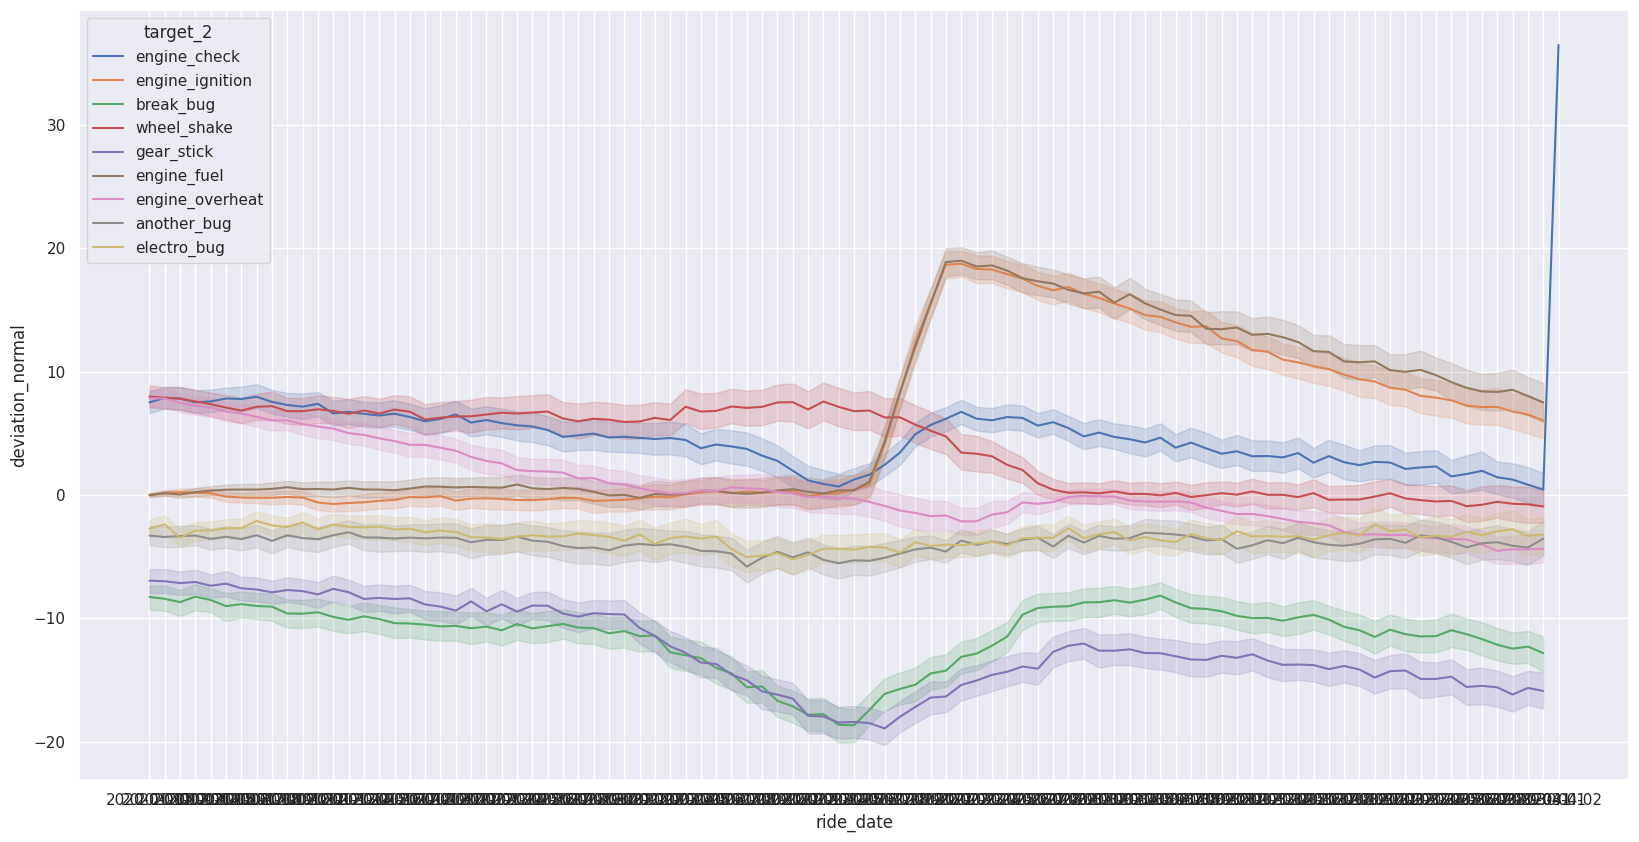

In [43]:
plt.figure(figsize=(20, 10))
sns.lineplot(data = rides_info, x = 'ride_date', y = 'deviation_normal', hue = 'target_2', legend=True); 
rides_info.head(1)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,target_1,target_2,real_slope,killer_fs
0,I13186944D,A-1068587k,o1A,2020-01-01,3.51,80238,1043089,38,52.0,3,3.128016e+06,0,-0.302421,-0.0,1,engine_check,-0.1,85


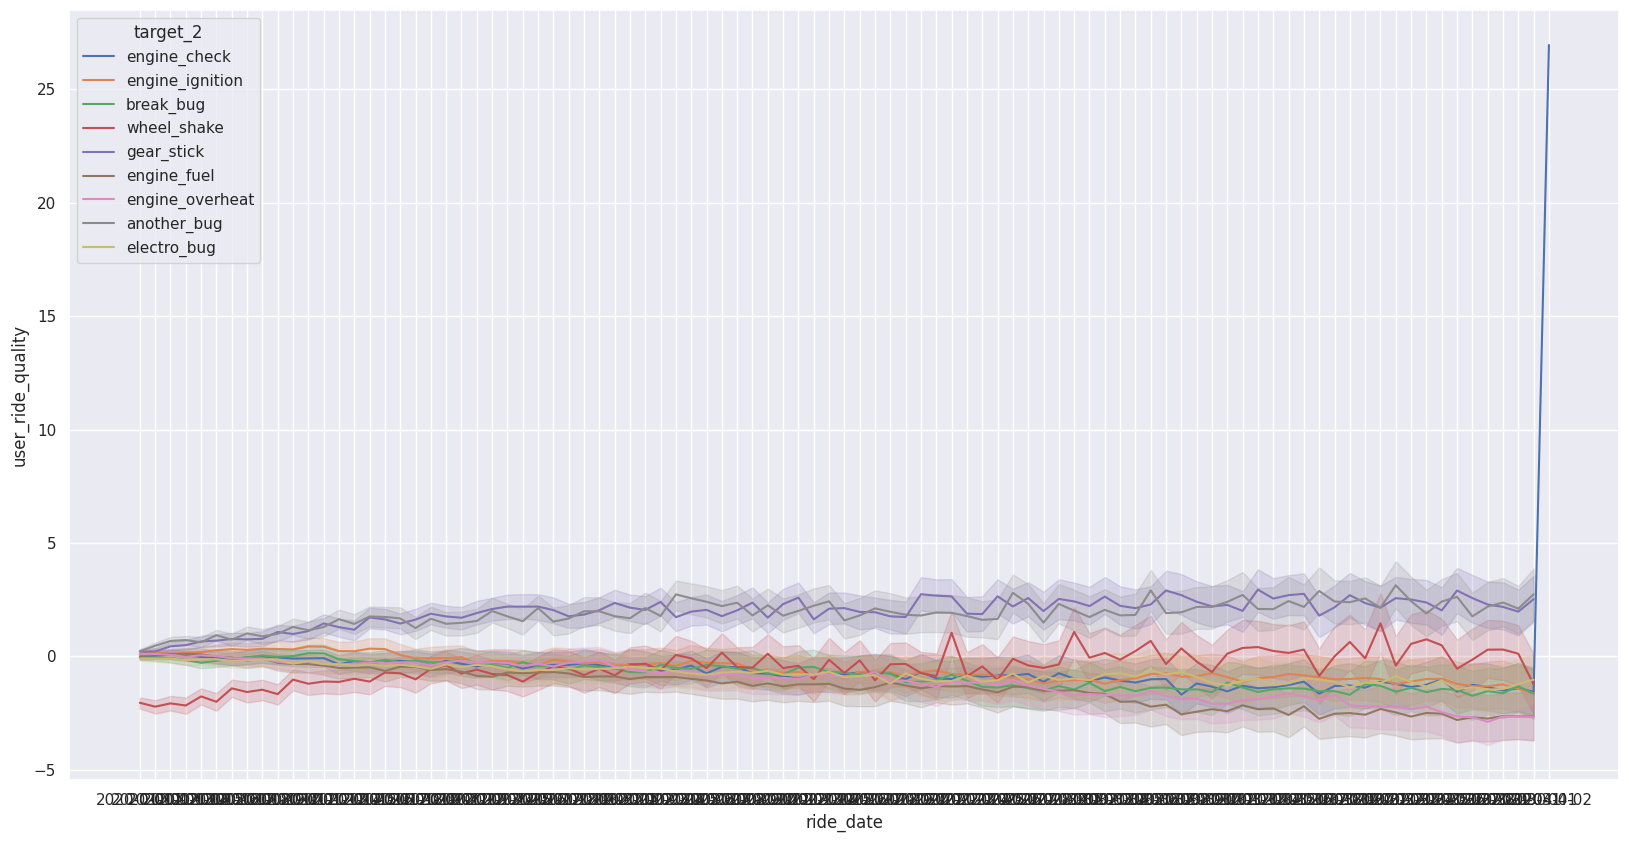

In [44]:
plt.figure(figsize=(20, 10))
sns.lineplot(data = rides_info, x = 'ride_date', y = 'user_ride_quality', hue = 'target_2', legend=True); 
rides_info.head(1)


# plt.figure(figsize=(20, 10))
# sns.lineplot(data = rides_info[rides_info['user_id'].isin(np.random.choice(rides_info['user_id'].unique(), size=100))], x = 'ride_date', y = 'user_ride_quality', hue = 'car_id', legend=False); 
# rides_info.head(1)

In [45]:
# sns.displot(data=rides_info, x='deviation_normal', aspect=3)

In [46]:
# sns.displot(data=rides_info, x='deviation_normal', hue='target_2', aspect=3);

In [47]:
# sns.displot(data=rides_info, x='deviation_normal', y='ride_date',
#             aspect=3, hue='target_2');

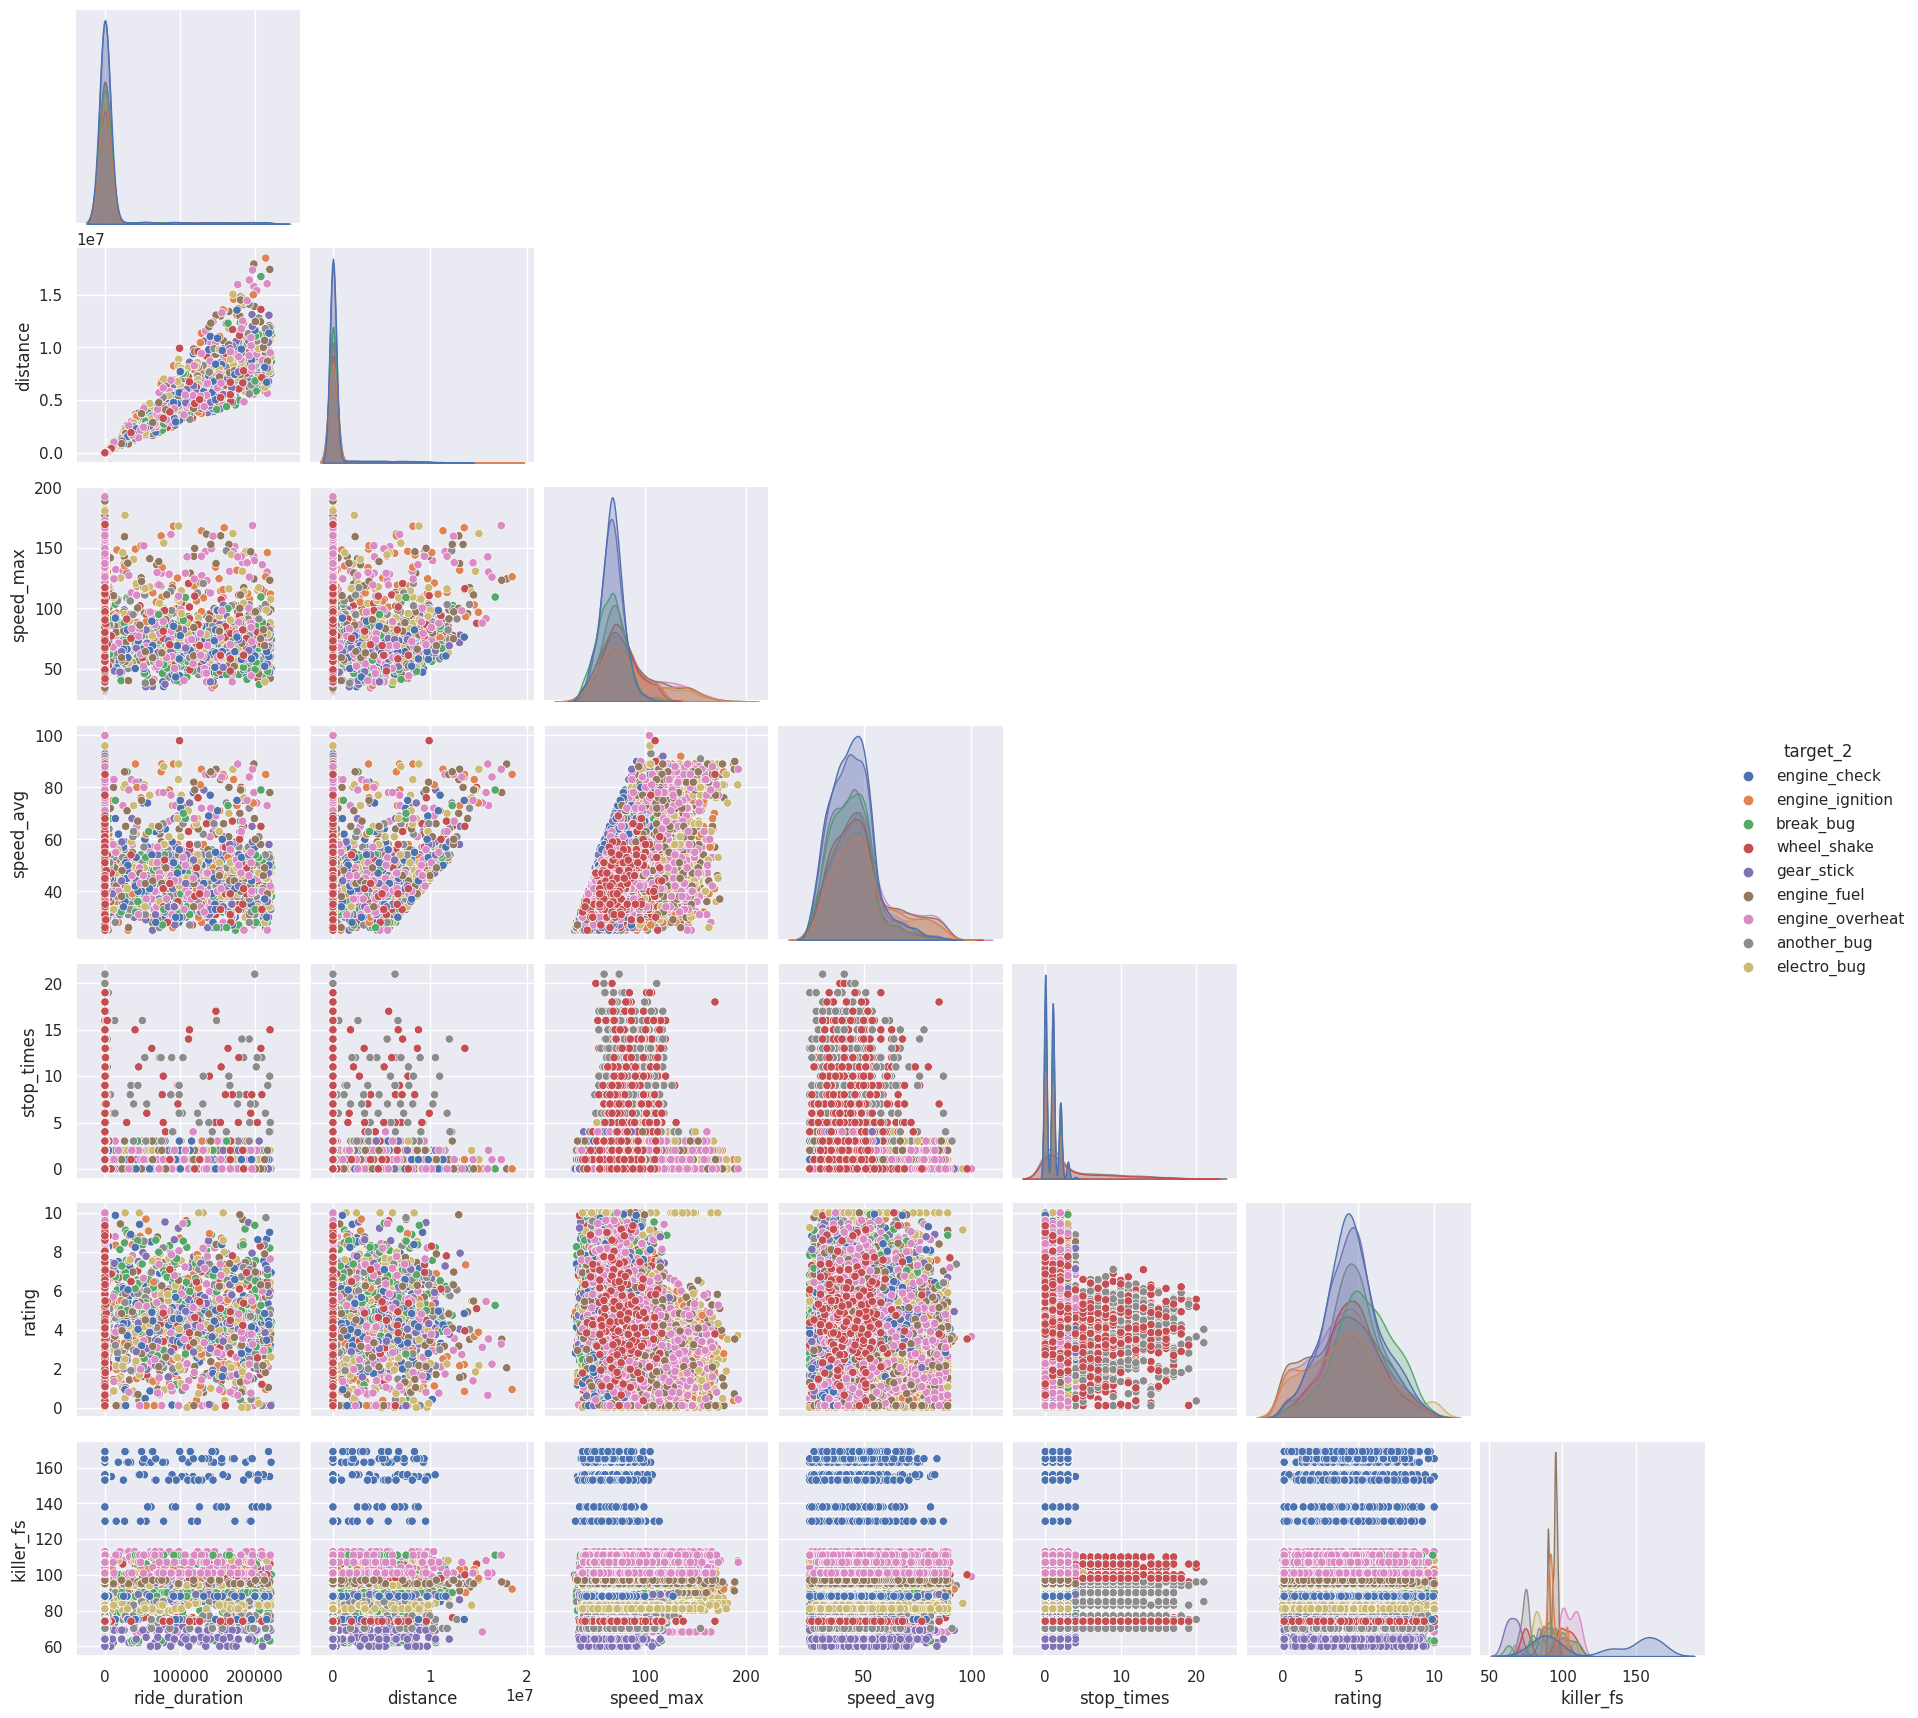

In [48]:
cols = ['ride_duration', 'distance', 'speed_max', 'speed_avg', 'target_2', 'stop_times', 'rating', 'killer_fs']
ids_car = rides_info['car_id'].unique()[:100]
tmp = rides_info[rides_info['car_id'].isin(ids_car)]
sns.pairplot(data = tmp[cols], hue = 'target_2', corner=True);

# Reduce Quality

0

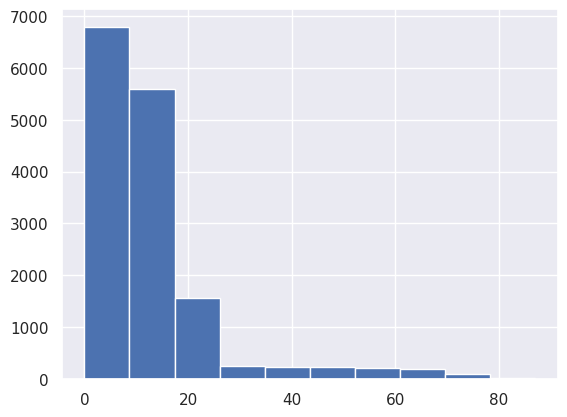

In [49]:
    
def make_nones(x):
    num = int(x.first_ride_date.split('-')[-1])
    
    if np.random.random() > 0.26 and x.user_time_accident > 25:
        return None

    if num % 5 == 0 and np.random.random() > 0.25 and x.user_time_accident > 65:
        return None
        
    return x.user_time_accident


        
rider_info = pd.read_csv('../data/tmp_driver_info.csv')
rider_info['user_time_accident'].hist()
rider_info['user_time_accident'].isnull().sum()

980

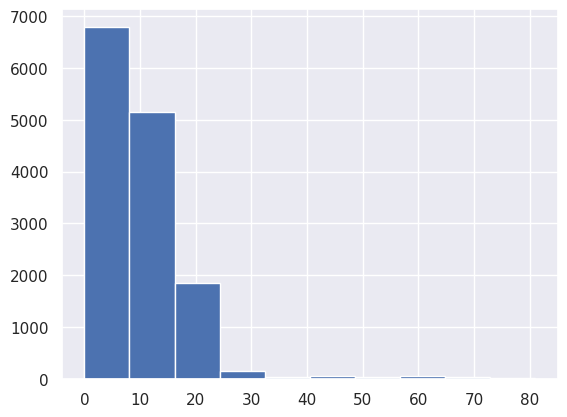

In [50]:
rider_info['user_time_accident'] = rider_info.apply(make_nones, axis=1)
rider_info.drop('eng_check', axis=1, errors = 'ignore').to_csv('../data/driver_info.csv', index=False)
rider_info['user_time_accident'].hist()
rider_info['user_time_accident'].isnull().sum()

In [51]:
# rides_info

# Добавляем сгенерированные фичи и далее от них генерируем таргет

In [52]:
# Добавляем признаки из информации про поездки

q_right = lambda x : sum(x > 120)/len(x)
f_low_r = lambda x : sum(x < 2.0)

# rides_info['real_slope'] = abs(rides_info['real_slope'])
rides_info_ = rides_info.merge(rider_info, on = 'user_id', how = 'left')


rides_info_['nan_user_ride_quality'] = rides_info_['user_ride_quality'].isnull()*1
rides_info_['high_user_ride_quality'] = rides_info_['user_ride_quality'].values > 10
rides_info_['nan_speed_max'] = rides_info_['speed_max'].isnull()*1


rides_info_gr = rides_info_.groupby('car_id', as_index=False).agg(
    ride_duration_sum = ('ride_duration', 'sum'),
    ride_distance_sum = ('distance', 'sum'),
    speed_avg_mean = ('speed_avg', 'mean'),
    speed_max_mean = ('speed_max', 'mean'),
    speed_max_q = ('speed_max', q_right),
    speed_max_max = ('speed_max', 'max'),
    
    mean_ride_cost = ('ride_cost', 'mean'),
    nan_sum = ('nan_user_ride_quality', 'max'),
    high_sum = ('high_user_ride_quality', 'max'),
    
    user_time_accident_max = ('user_time_accident', 'max'),
    user_time_accident_mean = ('user_time_accident', 'mean'),
    user_rating_min = ('user_rating', 'min'),
    user_rides_min = ('user_rides', 'min'),
    nan_speed_max = ('nan_speed_max', 'sum'),

    
    crit_low_r = ('rating', f_low_r),
    killer_fs = ('killer_fs', 'max'),
    # real_slope = ('real_slope', 'max'),
)


# Groupby + Transform

In [53]:
# (rides_info['real_slope'].value_counts().index - rides_info['real_slope'].min()) /  rides_info['real_slope'].max()
# rides_info_gr['real_slope'].value_counts(dropna=False)

In [54]:
fix_info['worker_experience'] = fix_info.groupby('worker_id')['car_id'].transform('count')

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration,worker_experience
0,Z16209094a,PJ,2020-6-20 2:14,reparking,1.0,21,309
1,J-1559355B,ZJ,2020-2-9 20:25,repair,10.0,48,282
2,I-1144396V,KL,2019-8-24 7:1,reparking,1.0,27,283
3,i14360916r,CP,2019-8-10 9:29,reparking,1.0,28,278
4,q13819346b,VZ,2020-11-12 5:22,refuel_check,1.0,22,240


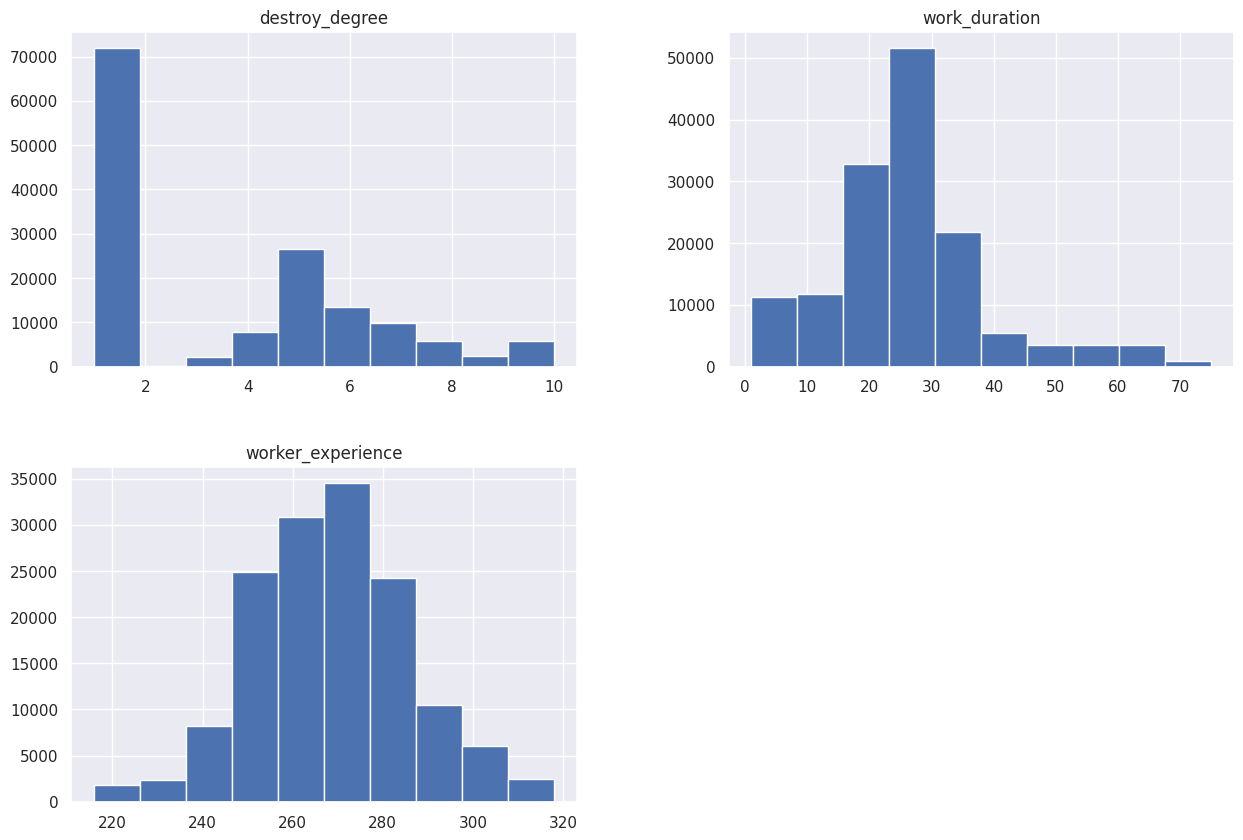

In [55]:
fix_info.hist(figsize = (15, 10))
fix_info.head()

# Fix_info + Pivot Table

In [56]:
# fix_info

fix_info_pivot = fix_info.pivot_table(index = 'car_id', columns = ['work_type'], values = ['destroy_degree'], aggfunc = ['mean', 'count'])#.columns
fix_info_pivot.columns = [f'{i[2]}_{i[0]}' for i in fix_info_pivot.columns]
fix_info_pivot.reset_index(inplace=True)
fix_info_pivot.sample(10)


,car_id,oil_change_mean,refuel_mean,refuel_check_mean,refuel_reparking_mean,repair_mean,reparking_mean,oil_change_count,refuel_count,refuel_check_count,refuel_reparking_count,repair_count,reparking_count
2536,e17100622M,NaN,3.666667,1.0,NaN,5.533333,1.000000,NaN,3.0,2.0,NaN,12.0,17.0
4194,z-2075956I,NaN,1.000000,1.0,NaN,6.645455,1.421053,NaN,2.0,2.0,NaN,11.0,19.0
3570,r-1568397k,NaN,1.000000,1.0,NaN,6.381250,1.562500,NaN,2.0,1.0,NaN,16.0,16.0
4239,z30748083x,NaN,1.000000,4.5,NaN,6.372222,2.230769,NaN,2.0,2.0,NaN,18.0,13.0
1246,P-1094526k,NaN,1.000000,1.0,NaN,4.853333,1.222222,NaN,1.0,1.0,NaN,15.0,18.0
353,D80715931S,NaN,4.750000,1.0,NaN,7.166667,1.000000,NaN,4.0,1.0,NaN,15.0,14.0
137,B-7538666a,NaN,1.000000,1.0,NaN,5.194118,1.000000,NaN,1.0,1.0,NaN,17.0,15.0
3547,q51056666l,NaN,1.000000,5.0,NaN,4.876190,1.727273,NaN,1.0,1.0,NaN,21.0,11.0
3501,q-7165662e,NaN,NaN,2.8,NaN,5.964286,1.533333,NaN,NaN,5.0,NaN,14.0,15.0
2351,c15895893k,NaN,3.000000,1.0,NaN,4.818750,1.307692,NaN,2.0,3.0,NaN,16.0,13.0


# Fix_info + Groupby

,car_id,worker_count,destroy_degree_max,destroy_degree_sum,work_duration_mean,work_duration_max,work_type_nuniq,work_type_moda,work_type_seconde_moda,work_type_crit_perc_q,work_type_crit_q,worker_experience_mean,worker_low_exp
1426,R-5179537S,34,9.0,148.0,27.411765,60,4,repair,refuel,0.147059,4,268.852941,0
3183,m-1905262u,34,5.0,114.8,26.794118,68,3,repair,refuel,0.000000,0,267.705882,0
3440,p21243837w,35,10.0,136.6,26.914286,62,3,repair,refuel_check,0.085714,3,267.400000,0
1019,L84824528l,34,5.0,103.0,26.176471,62,4,repair,refuel,0.000000,0,269.558824,0
2149,a-1619939H,34,5.0,86.9,24.823529,54,3,reparking,refuel_check,0.000000,0,271.705882,0


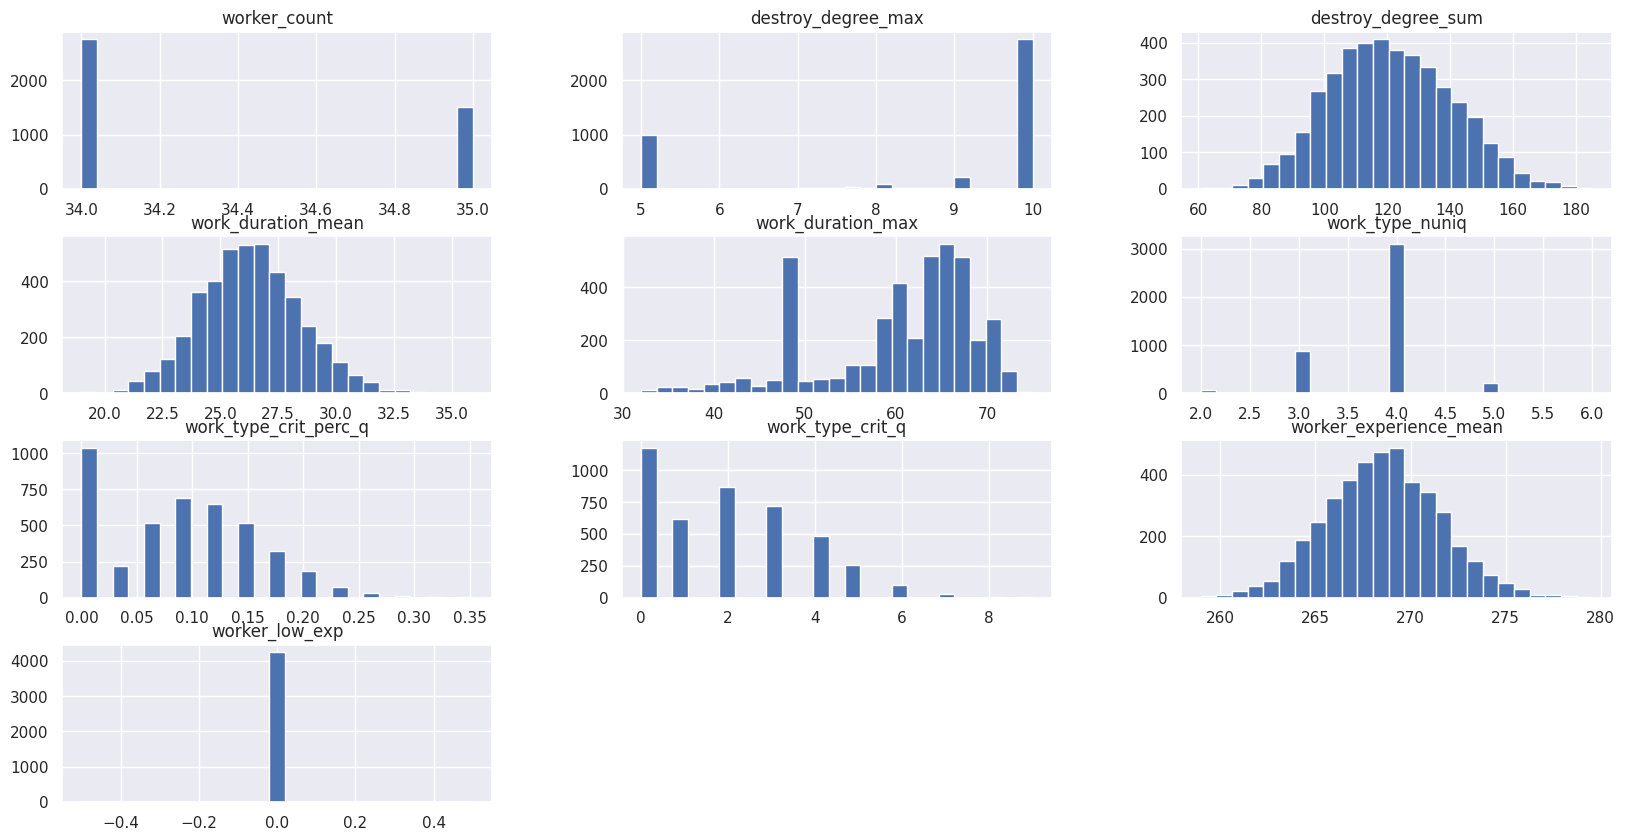

In [57]:
# Добавляем признаки из информации про ремонт

f_nuniq = lambda x : len(np.unique(x))
f_crit_perc_q = lambda x : sum(x >= 7.5)/len(x)
f_crit_q = lambda x : sum(x > 8.0)

avg_exp = fix_info['worker_experience'].median()
f_low_exp = lambda x: sum(x <= avg_exp*0.5)

# second_mode = lambda x: print( [ i for i in x if i not in [pd.Series.mode(x).values[0]] ] ) 
second_mode = lambda x: np.unique([ i for i in x if i not in [pd.Series.mode(x).values[0]] ])[0]

fix_info_gr = fix_info.groupby('car_id', as_index=False).agg(
    worker_count = ('worker_id', 'count'),
    destroy_degree_max = ('destroy_degree', 'max'),
    destroy_degree_sum = ('destroy_degree', 'sum'),
    work_duration_mean = ('work_duration', 'mean'),
    work_duration_max = ('work_duration', 'max'),
    work_type_nuniq = ('work_type', f_nuniq),
    
    work_type_moda = ('work_type', pd.Series.mode ),
    work_type_seconde_moda = ('work_type', second_mode),
    
    work_type_crit_perc_q = ('destroy_degree', f_crit_perc_q),
    work_type_crit_q = ('destroy_degree', f_crit_q),
    worker_experience_mean = ('worker_experience', 'mean'),
    worker_low_exp = ('worker_experience', f_low_exp),
)
fix_info_gr.hist(figsize = (20, 10), bins=25)
fix_info_gr.sample(5)

# Tsfresh + time series

In [58]:
!pip install tsfresh -q

In [59]:
# Добавляем признаки временные из информации про поездки с помощью TSfresh

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters
from tsfresh.utilities.distribution import MultiprocessingDistributor
from sklearn.feature_selection import VarianceThreshold
from datetime import datetime
import tsfresh

In [60]:
from tsfresh.feature_extraction import settings

settings_efficient = {}

settings_efficient = settings.TimeBasedFCParameters()
settings_efficient.update(settings.MinimalFCParameters())
# settings_efficient.update(settings.IndexBasedFCParameters())
settings_efficient.update(settings.IndexBasedFCParameters())
# settings_efficient.update(settings.EfficientFCParameters())

settings_efficient

{'linear_trend_timewise': [{'attr': 'pvalue'}, {'attr': 'rvalue'}, {'attr': 'intercept'}, {'attr': 'slope'}, {'attr': 'stderr'}], 'sum_values': None, 'median': None, 'mean': None, 'length': None, 'standard_deviation': None, 'variance': None, 'root_mean_square': None, 'maximum': None, 'absolute_maximum': None, 'minimum': None, 'skewness': None, 'kurtosis': None, 'percentage_of_reoccurring_datapoints_to_all_datapoints': None}

In [61]:
# rides_info.car_id.value_counts() #.head(3)

rides_info#['deviation_normal'].isnull().sum()

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,target_1,target_2,real_slope,killer_fs
0,I13186944D,A-1068587k,o1A,2020-01-01,3.51,80238,1043089,38,52.000000,3,3.128016e+06,0,-0.302421,-0.000,1,engine_check,-0.1,85
1,R97784496t,A-1068587k,F1X,2020-01-01,5.72,105756,1480577,45,64.000000,0,4.864626e+06,0,-0.499172,-0.000,1,engine_check,-0.1,85
2,I13694599a,A-1068587k,f1j,2020-01-02,5.57,5,60,73,93.602158,0,4.176389e+02,0,-1.548536,-5.000,1,engine_check,-0.1,85
3,T93834217S,A-1068587k,Q1u,2020-01-02,4.52,46,640,45,62.000000,0,2.122785e+03,0,-1.010666,-0.000,1,engine_check,-0.1,85
4,J40497939H,A-1068587k,C1X,2020-01-03,7.12,39,306,39,58.000000,1,1.261300e+03,0,-0.940802,-0.000,1,engine_check,-0.1,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739495,O18712245E,z96586459k,W1D,2020-03-30,2.76,139,1246,48,109.000000,10,2.153058e+03,0,2.639416,11.320,0,another_bug,-0.0,91
739496,T20625051e,z96586459k,u1R,2020-03-31,5.05,33,456,32,58.000000,2,8.937668e+02,0,0.669097,12.179,0,another_bug,-0.0,91
739497,S72456723t,z96586459k,I1x,2020-03-31,3.50,23,250,49,79.531720,0,1.005222e+03,0,-0.643290,21.914,0,another_bug,-0.0,91
739498,E15440781b,z96586459k,q1A,2020-04-01,5.89,152,1971,58,111.000000,12,2.208062e+03,0,-0.892063,10.705,0,another_bug,-0.0,91


In [62]:
settings = settings_efficient

# train_df.fillna(0, inplace=True)
res_train_df = None
# res_test_df = None

numeric_cols = ['deviation_normal', 'user_ride_quality']
vr = VarianceThreshold(0)
for num, num_col in enumerate(numeric_cols):
    now = datetime.now()
    print(num, 'col', num_col)
    
#     settings = full_settings_filtered[num_col]
    
    Distributor = MultiprocessingDistributor(n_workers=4,
                                             disable_progressbar=False,
                                             progressbar_title="Feature Extraction")

    X = extract_features(rides_info[["car_id", "ride_date", num_col]].fillna(0), 
#                                   y,
                                  column_id='car_id',
                                  column_sort='ride_date',
                                  n_jobs=1,
#                                   chunksize=5,
                                  default_fc_parameters=settings_efficient#settings,
#                                   fdr_level = 0.01,
#                                   distributor = Distributor
                        )
    
    X = pd.DataFrame(vr.fit_transform(X), columns=X.columns[vr.get_support()])
    print('прошло времени после генерации', datetime.now() - now)
        
    if res_train_df is None:
        res_train_df = X
#         res_train_df["target"] = rides_info['target_2']
        res_train_df["car_id"] = rides_info['car_id'].unique()
    else:
        # X = reduce_mem_usage(X)
        res_train_df = pd.concat([res_train_df, X], axis=1)
#         res_train_df.to_csv("./../tmp_data/del_full_train_tsfresh.csv", index=False)        
        print('прошло времени до сохраниения', datetime.now() - now)


0 col deviation_normal


Feature Extraction: 100%|██████████| 4250/4250 [00:02<00:00, 1422.43it/s]


прошло времени после генерации 0:00:03.201760
1 col user_ride_quality


Feature Extraction: 100%|██████████| 4250/4250 [00:03<00:00, 1377.40it/s]

прошло времени после генерации 0:00:03.319247
прошло времени до сохраниения 0:00:03.320080



Process ForkPoolWorker-5:
Process ForkPoolWorker-7:
Process ForkPoolWorker-8:
Process ForkPoolWorker-6:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self

In [63]:
# fix_info_pivot

# Собираем все таблицы в одну группу

In [64]:
print(car_info['car_id'].nunique())
car_info_fs = pd.merge(car_info, rides_info_gr, on = 'car_id', how = 'left')
print(car_info_fs['car_id'].nunique(), car_info_fs.shape[0])

car_info_fs = pd.merge(car_info_fs, fix_info_pivot, on = 'car_id', how = 'left')
print(car_info_fs['car_id'].nunique(), car_info_fs.shape[0])

car_info_fs = pd.merge(car_info_fs, fix_info_gr, on = 'car_id', how = 'left')
print(car_info_fs['car_id'].nunique(), car_info_fs.shape[0])


car_info_fs = pd.merge(car_info_fs, res_train_df, on = 'car_id', how = 'left')
print(car_info_fs['car_id'].nunique(), car_info_fs.shape)

car_info_fs.head()

4250
4250 4250
4250 4250
4250 4250
4250 (4250, 74)


,car_type,fuel_type,car_rating,year_to_start,riders,car_id,model,target_1,target_2,year_to_work,...,user_ride_quality__mean,user_ride_quality__standard_deviation,user_ride_quality__variance,user_ride_quality__root_mean_square,user_ride_quality__maximum,user_ride_quality__absolute_maximum,user_ride_quality__minimum,user_ride_quality__skewness,user_ride_quality__kurtosis,user_ride_quality__percentage_of_reoccurring_datapoints_to_all_datapoints
0,economy,petrol,4.90,2016,30228,Z16209094a,Smart Coupe,1,engine_overheat,2017,...,-4.377126,6.439629,41.468817,7.786401,11.759337,15.009839,-15.009839,0.329456,-0.749590,0.000000
1,standart,petrol,4.42,2015,14651,J-1559355B,Renault Kaptur,1,electro_bug,2017,...,-20.009017,10.417273,108.519572,22.558377,4.508529,42.126038,-42.126038,0.290517,0.082891,0.000000
2,economy,petrol,4.44,2011,52155,I-1144396V,VW Polo VI,0,break_bug,2017,...,12.776495,8.148641,66.400350,15.153850,24.723930,24.723930,-1.917469,-0.282524,-1.354262,0.000000
3,economy,petrol,3.62,2017,56425,i14360916r,Skoda Rapid,0,another_bug,2019,...,4.046376,3.945125,15.564010,5.651298,10.792778,10.792778,-6.913369,-0.655767,-0.152646,0.000000
4,economy,petrol,2.94,2013,27835,q13819346b,VW Tiguan,0,gear_stick,2020,...,-4.133928,8.076783,65.234425,9.073246,18.141082,18.141082,-16.720782,0.881609,-0.455393,0.034483


In [65]:
# car_info_fs['work_duration_mean'].hist()

# Отнормируем фичи, чтоб легче было слепить из них таргет

In [66]:
!pip install sklearn_pandas >> None

In [67]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import MinMaxScaler

to_scale_fs = ['car_rating', 'year_to_start', 'riders', 'ride_duration_sum', 'speed_avg_mean',
               'ride_distance_sum', 
               'speed_max_mean', 'speed_max_q', 'speed_max_max', 'crit_low_r', 'worker_count',
               'destroy_degree_max', 'destroy_degree_sum', 'work_duration_mean', 'work_duration_max',
               'work_type_nuniq', 'work_type_crit_perc_q', 'work_type_crit_q', 'worker_experience_mean', 
               
               
               'user_time_accident_max', 'user_rating_min', 'user_rides_min',
               
               # 'real_slope',
               'killer_fs',
               
               # 'deviation_normal__linear_trend__attr_"slope"', 
               'repair_count', 'refuel_check_count', 'repair_mean'
              ]

not_to_scale_fs = [c for c in car_info_fs.columns if c not in to_scale_fs]

mapper = DataFrameMapper([(to_scale_fs, MinMaxScaler())])
scaled_features = mapper.fit_transform(car_info_fs.copy(), 4)
car_info_fs_ = pd.DataFrame(scaled_features,
                            index = car_info_fs.index,
                            columns = to_scale_fs)

car_info_fs_ = pd.concat([car_info_fs_, car_info_fs[not_to_scale_fs]], axis=1)

print('car_info_fs_', car_info_fs_.shape)
print('car_info_fs', car_info_fs.shape)
car_info_fs_.sample(5)

car_info_fs_ (4250, 74)
car_info_fs (4250, 74)


,car_rating,year_to_start,riders,ride_duration_sum,speed_avg_mean,ride_distance_sum,speed_max_mean,speed_max_q,speed_max_max,crit_low_r,...,user_ride_quality__mean,user_ride_quality__standard_deviation,user_ride_quality__variance,user_ride_quality__root_mean_square,user_ride_quality__maximum,user_ride_quality__absolute_maximum,user_ride_quality__minimum,user_ride_quality__skewness,user_ride_quality__kurtosis,user_ride_quality__percentage_of_reoccurring_datapoints_to_all_datapoints
1413,0.457071,0.666667,0.322818,0.408659,0.649299,0.377395,0.786950,0.714286,0.745720,0.596154,...,-1.970536,2.642403,6.982295,3.296256,4.892786,6.916973,-6.916973,0.525861,-0.423871,0.0
2575,0.479798,0.333333,0.143941,0.489591,0.356713,0.437097,0.203784,0.000000,0.196564,0.076923,...,23.278781,11.366688,129.201587,25.905660,40.770929,40.770929,1.146548,-0.381726,-1.141902,0.0
3430,0.409091,0.333333,0.306891,0.491049,0.538076,0.548331,0.613845,0.551020,0.681052,0.615385,...,-11.473306,5.432292,29.509800,12.694351,3.305641,19.910488,-19.910488,0.351179,-0.945087,0.0
2584,0.525253,0.666667,0.258628,0.630866,0.543587,0.656657,0.616217,0.408163,0.768832,0.480769,...,0.374674,5.052329,25.526024,5.066202,8.914097,10.002054,-10.002054,-0.382866,-0.809075,0.0
1887,0.406566,0.666667,0.363599,0.372536,0.516533,0.365447,0.696129,0.530612,0.625918,0.673077,...,4.594873,6.967701,48.548860,8.346359,16.954717,16.954717,-6.529990,-0.024518,-1.417983,0.0


In [68]:
# len([col for col in car_info_fs_.columns if col in car_info_fs.columns])
car_info_fs_.shape

(4250, 74)

In [69]:
# car_info_fs_.columns[car_info_fs_.columns.duplicated()]

In [70]:
car_info_fs_[to_scale_fs].head(2)

,car_rating,year_to_start,riders,ride_duration_sum,speed_avg_mean,ride_distance_sum,speed_max_mean,speed_max_q,speed_max_max,crit_low_r,...,work_type_crit_perc_q,work_type_crit_q,worker_experience_mean,user_time_accident_max,user_rating_min,user_rides_min,killer_fs,repair_count,refuel_check_count,repair_mean
0,0.494949,0.833333,0.441553,0.433933,0.713427,0.392939,0.783838,0.653061,0.669866,0.884615,...,0.161905,0.222222,0.489898,0.125000,0.090909,0.000000,0.309735,0.333333,0.111111,0.405804
1,0.434343,0.666667,0.213945,0.371034,0.919840,0.389219,0.725092,0.612245,0.813626,0.576923,...,0.728571,0.555556,0.367770,0.078125,0.272727,0.023256,0.088496,0.523810,0.111111,0.637246


In [71]:
car_info_fs['target_2'].value_counts()

engine_check       502
gear_stick         500
another_bug        495
engine_fuel        493
engine_overheat    491
break_bug          491
engine_ignition    486
electro_bug        470
wheel_shake        322
Name: target_2, dtype: int64

In [72]:
# car_info_fs['real_slope'].value_counts(dropna=False)
# TODO не все машины есть в трейне!

In [73]:
def get_base_time_accident(x):
    
    # Фичи из rides_info
    
    ride_duration_sum = x.ride_duration_sum
    speed_avg_mean = x.speed_avg_mean
    speed_max_mean = x.speed_max_mean
    speed_max_q = x.speed_max_q
    speed_max_max = x.speed_max_max
    crit_low_r = x.crit_low_r
    
    worker_low_exp = x.worker_low_exp
    
    worker_experience_mean = x.worker_experience_mean
    
    
     # Фичи из car_info
    # Поездки / пробег / разрушения 
    A = (2 - x.ride_distance_sum + np.random.random()/10)*(2 - (x.destroy_degree_sum)**2)*(2 - x.destroy_degree_max + np.random.random()/10)*(2 - x.riders + np.random.random()/10 )/3
    
    # Фичи из fix_info 
    # Средний опыт рабочих / Число слабых рабочих / Рабочий осмотр
    B = (1 + (x.worker_experience_mean + np.random.random()/10)**2)*(2 - x.worker_low_exp)*(1 + x.work_duration_mean)*(2 - x.destroy_degree_max)*(2 - x.work_type_crit_q)/4 # Перепроверить

    
    # Тренд взависимости от Таргета
    C = 1 # (2 - x.real_slope)*(2 + (x['deviation_normal__linear_trend__attr_"slope"'])**2)
    
    D = (2 + x.killer_fs + np.random.random()/10)
    
    E = (2 - x.repair_count)*(2 + x.refuel_check_count)*(2 - x.repair_mean) / 3
    
    F = (2 - x.repair_mean + np.random.random()/10)*(2 - x.work_duration_max + np.random.random()/20)*(3 + x.work_type_nuniq  + np.random.random()/30 )
    
    # Фичи из driver_info
    H = (2 - x.user_time_accident_max - np.random.random()/10)*(2 + x.user_rating_min - np.random.random()/100)*(2 + x.user_rides_min - np.random.random()/10)
    
    base_time_positive = A*B*C*D*E*F*H
    
    return base_time_positive

In [74]:
# TODO

# - Добавить связь модель машины - таргет, чтоб кат фичи были важны
# - Добить генерацию численного таргета
# - Добавить связь - User_id-Car_id
# - Отвалидировать рост точности исходя из добавления фичей
# - Добавить третий ранжирующий таргет по порядку позиций поломок
# - добавить выбросы в work_duration_max 

In [75]:
 # np.random.random()

* engine_check
Индикатор «Чек двигателя» -  Этот индикатор на приборке загорается, когда ЭБУ (электронный блок управления двигателем) 
обнаруживает в системе код ошибки в работе какой-либо системы. Например, это происходит, когда ошибку выдает датчик.

* engine_overheat
Перегрев двигателя - Наиболее частой причиной перегрева двигателя является утечка охлаждающей жидкости.
Например, чаще утечка антифриза связана с разгерметизацией радиатора охлаждения, поломкой водяной помпы или с повреждением расширительного бачка. Чтобы уменьшить риск перегрева мотора, нужно заранее менять радиатор и помпу. 

* engine_ignition
Пропуск зажигания — это явление, при котором по какой-то причине воспламенение не произошло, 
Машина ускоряется неровно, набор скорости ей дается тяжело. Неровный холостой ход. Вы можете почувствовать, что машина вибрирует. 
Дело в том, двигатель работает не сбалансированно из-за одного или нескольких неработающих цилиндров

* engine_fuel
Большой расход топлива - Когда двигатель работает эффективно, он сжигает топливо со скоростью, которая помогает эффективно 
расходовать топливо (экономия топлива). Однако некоторые детали топливной системы, такие как топливные фильтры, воздушные фильтры,
датчик массового расхода воздуха и кислородные датчики (лямба-зонд), со временем загрязняются и изнашиваются.

* electro_bug
Разряженный аккумулятор - Срок службы автомобильных аккумуляторов в среднем составляет 3-4 года, или 80 000-100 000 км. 
Батарея обычно стареет со временем, как и любой аккумулятор в вашем смартфоне. Чем чаще батарея проходит циклы разрядки/зарядки, тем быстрее она теряет способность поддерживать нормальный уровень заряда и определенное количество ампер.

* break_bug
Скрип тормозов - тормозная система подвержена износу в течение определенного времени. Тормоза жизненно важны для безопасной остановки.
Поэтому когда вы замечаете какие-либо признаки проблем, такие как визг, скрип или если, например, педаль тормоза стала мягкой, 

* wheel_shake
Дрожание рулевого колеса - Многочисленные проблемы могут вызвать дрожание/дребезжание рулевого колеса во время вождения.
Если это происходит сразу после запуска двигателя и начала вождения, причиной дрожания руля могут быть подшипники колес или поврежденные компоненты подвески. Если это происходит на более высоких скоростях, обычно это говорит о проблеме с балансировкой колес. 

* gear_stick
Неисправность автоматической коробки передач - При правильном обслуживании автоматическая коробка передач может без проблем работать более 300 000 км.
Современная автоматическая трансмиссия представляет собой гидравлическую систему, состоящую из нескольких сальников, прокладок и линий, которые могут быть повреждены, забиты мусором или протекать.
В большинстве случаев используемые сегодня автоматические коробки  передач при правильной эксплуатации и своевременном обслуживании могут потребовать капитальный ремонт при пробеге не ранее 150.000 километров.


engine_check engine_overheat engine_ignition fuel electro_bug break_bug wheel gear_stick

* `target_1` - int
* `target_2` - int

In [76]:
# car_info_fs.columns.tolist() #.riders.value_counts()

In [77]:
def make_target(x):
    
    intersept = 100
    # Все таргеты зависят от числа поездок!!!!!!!!!!!!
    # Далее просто берем разные коэффициенты и снижаем время службы 
    target_2 = x.target_2
    base_time_positive = get_base_time_accident(x)
    
    model = car_model_conditions[x.model]['aging_coef']
    
    if target_2 == 'engine_fuel': # Что-то классические
        # Временной изгиб и далее аномалии в расходе топлива.
        target_1 = 1100*(1 + model)*base_time_positive + intersept + np.random.random()*10

    elif target_2 == 'engine_check':
        target_1 = 1000*(1 + model)*base_time_positive + intersept + np.random.random()*10
        # Аномалии из-за агресивного вождения машиной.
        # Если в показательно ТО преломился, то до следующего перелома остается 15 дней
         
        
    elif target_2 == 'engine_overheat':
        target_1 = 1000*(1 + model)*base_time_positive + intersept
        # Долго не проверяли машину. Время с последней проверки определенного ТО. 
        # Количество аномальных скоростей
         

    elif target_2 == 'engine_ignition':
        target_1 = 1100*(1 + model)*base_time_positive + intersept + np.random.random()*10
        # Связанно с часто плохим user_ride_quality. Зависимость не линейная
        # Если качество поедки в среднем держится низко, то машина в скором времени перестает заводиться

    elif target_2 == 'gear_stick':
        # Что-то, что приводит к частым остановкам
        # Часто низкое качество поездки. 
        # Число остановок выше среднего
        # Количество выбросов в ТО, если больше 25, то осталось 15 дней + качество поездки
        target_1 = 1200*base_time_positive + intersept + np.random.random()*10
        
    elif target_2 == 'break_bug':
        target_1 = 1500*base_time_positive + intersept + np.random.random()*10
        # Возможно после частых высоких средних скоростей
        # Качество вождание часто низкое. 
        # Проблемы с тормозом. Возможно ниже рейтинг. Возможно показатели хуже
         
    
    elif target_2 == 'electro_bug':
        target_1 = 1700*base_time_positive + intersept + np.random.random()*10
        #  Количество поездок с нулевым расстоянием
        #  Колличество выбросов низких оценок увеличивается со временем
         
            
    elif target_2 == 'wheel_shake':
        target_1 = 1600*base_time_positive + intersept + np.random.random()*10
        # Аномалии в движении машины. 
        # Качество вождения нормальное, но есть негативный тренд в ТО
         
        
    else:
        target_1 = 5000*base_time_positive + intersept + np.random.random()*10
        
    return target_1
    
car_info_fs['target_1'] = car_info_fs_.apply(make_target, axis=1)

# car_info_fs[cols].to_csv('../data/rides_info.csv', index=False)

car_info_fs.sample(5)

,car_type,fuel_type,car_rating,year_to_start,riders,car_id,model,target_1,target_2,year_to_work,...,user_ride_quality__mean,user_ride_quality__standard_deviation,user_ride_quality__variance,user_ride_quality__root_mean_square,user_ride_quality__maximum,user_ride_quality__absolute_maximum,user_ride_quality__minimum,user_ride_quality__skewness,user_ride_quality__kurtosis,user_ride_quality__percentage_of_reoccurring_datapoints_to_all_datapoints
148,economy,petrol,3.26,2015,12998,d12372286F,Smart ForTwo,1.745905e+06,engine_overheat,2015,...,-5.134280,4.231474,17.905372,6.653285,4.440251,16.620230,-16.620230,-0.313449,-0.288980,0.0
3700,economy,petrol,4.96,2015,16963,i-2032990h,Kia Rio,NaN,engine_check,2019,...,0.315910,1.811898,3.282975,1.839232,4.704374,4.704374,-4.009284,0.253329,-0.214306,0.0
346,economy,petrol,5.42,2014,1604,S-1897022t,Kia Rio X-line,4.694499e+06,engine_check,2020,...,-7.169943,3.736151,13.958821,8.084980,1.957186,15.568613,-15.568613,0.544179,-0.335023,0.0
2545,economy,petrol,3.94,2017,51849,c56809342i,Smart ForTwo,2.471280e+05,engine_fuel,2018,...,-9.922979,6.413771,41.136453,11.815328,5.571817,22.315503,-22.315503,0.450544,-0.175748,0.0
1651,economy,petrol,4.42,2014,2489,y-4453217w,Smart Coupe,5.600151e+06,engine_check,2021,...,-1.082432,5.182292,26.856147,5.294129,8.685739,10.436239,-10.436239,-0.067934,-1.321210,0.0


In [78]:
pd.merge(car_info.drop('target_1', axis=1), car_info_fs[['car_id', 'target_1']],
         on ='car_id', how='left').drop('killer_fs', axis=1, errors = 'ignore').to_csv('../data/car_info.csv', index=False)

In [79]:
# TODO добавить выборку для валидации

In [80]:
# car_info_fs[car_info_fs['target_1'].isnull()]

# car_info_fs.hist(figsize = (15, 15));

#TODO среднее по 10 критическим поездкам

346


<AxesSubplot: >

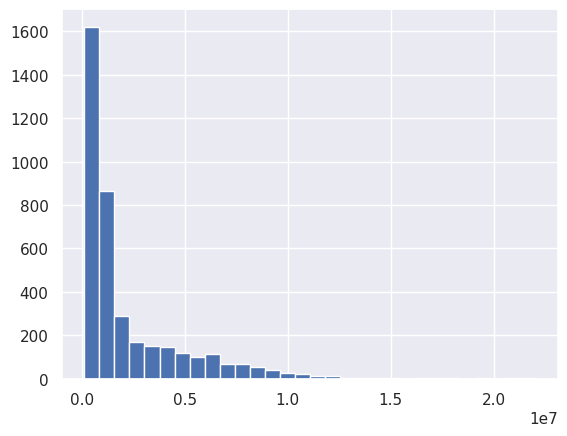

In [81]:
print(car_info_fs['target_1'].isnull().sum())
car_info_fs['target_1'].hist(bins=30)

In [82]:
# cols = [c for c in car_info_fs.columns if c not in res_train_df.columns]
# sns.pairplot(data=car_info_fs[cols].sample(500), corner=True, hue='target_2');

In [83]:
# car_info_fs.columns

# car_info_fs['car_id'].value_counts().hist()

# car_info_fs[car_info_fs['car_id'] == 'F19793670T']
car_info_fs.head()

,car_type,fuel_type,car_rating,year_to_start,riders,car_id,model,target_1,target_2,year_to_work,...,user_ride_quality__mean,user_ride_quality__standard_deviation,user_ride_quality__variance,user_ride_quality__root_mean_square,user_ride_quality__maximum,user_ride_quality__absolute_maximum,user_ride_quality__minimum,user_ride_quality__skewness,user_ride_quality__kurtosis,user_ride_quality__percentage_of_reoccurring_datapoints_to_all_datapoints
0,economy,petrol,4.90,2016,30228,Z16209094a,Smart Coupe,1.073419e+06,engine_overheat,2017,...,-4.377126,6.439629,41.468817,7.786401,11.759337,15.009839,-15.009839,0.329456,-0.749590,0.000000
1,standart,petrol,4.42,2015,14651,J-1559355B,Renault Kaptur,7.028130e+05,electro_bug,2017,...,-20.009017,10.417273,108.519572,22.558377,4.508529,42.126038,-42.126038,0.290517,0.082891,0.000000
2,economy,petrol,4.44,2011,52155,I-1144396V,VW Polo VI,6.207119e+05,break_bug,2017,...,12.776495,8.148641,66.400350,15.153850,24.723930,24.723930,-1.917469,-0.282524,-1.354262,0.000000
3,economy,petrol,3.62,2017,56425,i14360916r,Skoda Rapid,3.628444e+06,another_bug,2019,...,4.046376,3.945125,15.564010,5.651298,10.792778,10.792778,-6.913369,-0.655767,-0.152646,0.000000
4,economy,petrol,2.94,2013,27835,q13819346b,VW Tiguan,7.540935e+05,gear_stick,2020,...,-4.133928,8.076783,65.234425,9.073246,18.141082,18.141082,-16.720782,0.881609,-0.455393,0.034483


In [84]:
!pip install catboost -q

In [85]:
from sklearn.model_selection import KFold # k-фолдная валидация
from catboost import Pool, CatBoostClassifier, CatBoostRegressor 
import gc 

gc.collect()

0

# Разделяем фичи на группы (удаляем килер фичи)

In [86]:
killer_fs_to_drop = ['killer_fs', 'destroy_degree_max', 'work_type_crit_q', 'worker_low_exp', 
                     'refuel_check_count', 'repair_mean', 'repair_count', 'ride_distance_sum']

drop_features = ['car_id', 'target_1', 'target_2', 'real_slope'] #+ killer_fs_to_drop
targets = ['target_2']  # target_1
cat_features = ['car_type', 'fuel_type', 'model', 'work_type_moda', 'work_type_seconde_moda']

filtered_features = [i for i in car_info_fs.columns if (i not in targets and i not in drop_features)] #+ cat_features 
num_features = [i for i in filtered_features if i not in cat_features]


print('cat_features', cat_features)
# print('filtered_features', filtered_features)
# print('num_features', num_features)
print('targets', targets)

for c in cat_features:
    car_info_fs[c] = car_info_fs[c].astype(str)

cat_features ['car_type', 'fuel_type', 'model', 'work_type_moda', 'work_type_seconde_moda']
targets ['target_2']


In [87]:
!pip install iterative-stratification >> None 

In [88]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


def make_multi_target(df, target = 'target_2'):
    
    if target in df.columns:
    
        one_hot = pd.get_dummies(df[target])
        df = df.drop(target, axis = 1)
        df = df.join(one_hot)
    
    return df


def create_folds(data, num_splits=3, targets = [0, 1, 2, 4]):
    if num_splits > 1:
        data['kfold'] = -1
        X = data
        y = data[targets]
        mskf = MultilabelStratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

        for fold, (trn_, val_) in enumerate(mskf.split(X, y)):
            data.loc[val_,'kfold'] = fold
    else:
        data.loc[:,'kfold'] = 0
        
    return data

kfolds = 4

targets = car_info.target_2.unique()
# car_info_fs = make_multi_target(car_info_fs, target = 'target_2')
# car_info_fs = create_folds(car_info_fs, num_splits=kfolds, targets = targets)

# car_info_fs = (car_info_fs
      # .pipe(make_multi_target, target = 'target_2')
      # .pipe(create_folds, num_splits = kfolds, targets = targets)
     # )

car_info_fs.head()

,car_type,fuel_type,car_rating,year_to_start,riders,car_id,model,target_1,target_2,year_to_work,...,user_ride_quality__mean,user_ride_quality__standard_deviation,user_ride_quality__variance,user_ride_quality__root_mean_square,user_ride_quality__maximum,user_ride_quality__absolute_maximum,user_ride_quality__minimum,user_ride_quality__skewness,user_ride_quality__kurtosis,user_ride_quality__percentage_of_reoccurring_datapoints_to_all_datapoints
0,economy,petrol,4.90,2016,30228,Z16209094a,Smart Coupe,1.073419e+06,engine_overheat,2017,...,-4.377126,6.439629,41.468817,7.786401,11.759337,15.009839,-15.009839,0.329456,-0.749590,0.000000
1,standart,petrol,4.42,2015,14651,J-1559355B,Renault Kaptur,7.028130e+05,electro_bug,2017,...,-20.009017,10.417273,108.519572,22.558377,4.508529,42.126038,-42.126038,0.290517,0.082891,0.000000
2,economy,petrol,4.44,2011,52155,I-1144396V,VW Polo VI,6.207119e+05,break_bug,2017,...,12.776495,8.148641,66.400350,15.153850,24.723930,24.723930,-1.917469,-0.282524,-1.354262,0.000000
3,economy,petrol,3.62,2017,56425,i14360916r,Skoda Rapid,3.628444e+06,another_bug,2019,...,4.046376,3.945125,15.564010,5.651298,10.792778,10.792778,-6.913369,-0.655767,-0.152646,0.000000
4,economy,petrol,2.94,2013,27835,q13819346b,VW Tiguan,7.540935e+05,gear_stick,2020,...,-4.133928,8.076783,65.234425,9.073246,18.141082,18.141082,-16.720782,0.881609,-0.455393,0.034483


In [89]:
# car_info_fs.columns

In [90]:
# car_info_fs.columns.tolist()

# Catboost Classifier

In [91]:
# targets_dict = {'nothing' : 0, 'soft_1' : 1, 'soft_2' : 2, 'critical' : 4}
# f_map = lambda x: targets_dict.get(x, x)
# car_info_fs['target_2'] = car_info_fs['target_2'].map(f_map)

best_fs = ['ride_distance_sum','destroy_degree_sum','destroy_degree_max','riders','worker_experience_mean',
    'worker_low_exp','work_duration_mean','destroy_degree_max','work_type_crit_q','killer_fs',
    'repair_count','refuel_check_count','repair_mean','repair_mean','work_duration_max',
    'work_type_nuniq','user_time_accident_max','user_rating_min','user_rides_min']

In [92]:
target_dict  = {
    'engine_ignition' : 0,
    'engine_fuel' : 4,
    'another_bug' : 1,
    'engine_overheat' : 2,
    'gear_stick' : 3,
    'engine_check' : 5,
    'break_bug' : 6,
    'wheel_shake' : 7,
    'electro_bug' : 8}

f = lambda x: target_dict.get(x, x)
car_info_fs['target_2'] = car_info_fs['target_2'].apply(f)


In [93]:
# {'Recall:class=6': 1.0, 
#  'Recall:class=5': 1.0, 
#  'Recall:class=3': 1.0, 
#  'Recall:class=8': 1.0, 
#  'Recall:class=2': 1.0, 
#  'Recall:class=7': 1.0, 
#  'Recall:class=1': 1.0, 
 
#  'Recall:class=0': 0.98, 
#  'Recall:class=4': 0.9642857142857143,

 
#  'AUC:type=Mu': 0.9996575516171381, 
#  'MultiClass': 0.060581287801266835, 'Accuracy': 0.984}



In [94]:


# engine_overheat electro_bug gear_stick another_bug

In [95]:
# [c for c in filtered_features if c in best_fs]

features_gr = {
    'group_1' : ['car_type', 'fuel_type', 'car_rating', 'year_to_start', 'riders', 'model', 'year_to_work',
                 'work_type_moda','work_type_seconde_moda',],
    
    'group_2' : ['user_ride_quality__sum_values','user_ride_quality__median','user_ride_quality__mean','user_ride_quality__standard_deviation',
     'user_ride_quality__variance','user_ride_quality__root_mean_square','user_ride_quality__maximum','user_ride_quality__absolute_maximum',
     'user_ride_quality__minimum','user_ride_quality__skewness','user_ride_quality__kurtosis'],
    
    
    'group_3' : ['deviation_normal__sum_values','deviation_normal__median','deviation_normal__mean','deviation_normal__standard_deviation',
     'deviation_normal__variance','deviation_normal__root_mean_square','deviation_normal__maximum','deviation_normal__absolute_maximum',
     'deviation_normal__minimum','deviation_normal__skewness','deviation_normal__kurtosis','deviation_normal__percentage_of_reoccurring_datapoints_to_all_datapoints'],
    
    
    'group_4' : ['worker_count','destroy_degree_max','destroy_degree_sum','work_duration_mean','work_duration_max','work_type_nuniq',
                 # 'work_type_moda','work_type_seconde_moda',
     'work_type_crit_perc_q','work_type_crit_q','worker_experience_mean','worker_low_exp'],
    
    
    'group_5' : ['refuel_reparking_mean','refuel_mean','reparking_mean','repair_mean','refuel_check_mean', 'refuel_reparking_count',
                 'refuel_count','reparking_count','repair_count','refuel_check_count'],
    
    
    'group_6' : ['ride_duration_sum','ride_distance_sum',
                 'speed_avg_mean','speed_max_mean','speed_max_q',
                 'speed_max_max', 'user_time_accident_mean',
                 # 'user_time_accident_max',
                 'user_rating_min','user_rides_min','crit_low_r'],
    
    'group_6_2' : ['user_time_accident_max'],
    
    'group_7' : ['killer_fs'],
    
    
    'group_8' : ['nan_sum'],
    
    'group_9' : ['high_sum'], 
    
    'group_10' : ['mean_ride_cost'],
    
    'group_11' : ['nan_speed_max']
}
    
    
# features_gr
    
cat_features = ['car_type', 'fuel_type', 'model']
cat_features = ['car_type', 'fuel_type', 'model', 'work_type_moda', 'work_type_seconde_moda']

In [96]:
# print(huge_train_final.columns)
# huge_train_final = huge_train_final

from sklearn.model_selection import train_test_split


random_state = 42
n_splits = 3 # kfolds
print('num folds', n_splits)
clfs = []

targets = ['target_2']

# параметры валидации, обучение будет идти на 6 X n_splits фолдах

kFold_random_state = [42]# , 666, 228, 777, 2021, 75]
N = len(kFold_random_state)*n_splits

kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

best_fs = ['ride_distance_sum','destroy_degree_sum','destroy_degree_max','riders','worker_experience_mean',
    'worker_low_exp','work_duration_mean','destroy_degree_max','work_type_crit_q','killer_fs',
    'repair_count','refuel_check_count','repair_mean','repair_mean','work_duration_max',
    'work_type_nuniq','user_time_accident_max','user_rating_min','user_rides_min']

# # Тренд взависимости от Таргета
# C = 1 # (2 - x.real_slope)*(2 + (x['deviation_normal__linear_trend__attr_"slope"'])**2)
ignored_features = []#['car_rating', 'model']
ignored_features_dict = {}
filtered_features = []
for num_i, (gr, fs) in enumerate(features_gr.items()):
    
    
    filtered_features += fs# ignored_features+=[fs]
    
    print(gr, len(fs), 'total: ', len(filtered_features))
    
    X = car_info_fs[filtered_features].drop(targets, axis=1, errors='ignore')#.copy()
    y = car_info_fs[targets]#.copy()

    X, test_data, y, y_data = train_test_split(X, y, stratify=y.values, test_size=0.45, random_state = 7575,
                                              )
    
    test_data['target_2'] = y_data
    test_data.to_csv('../data/test_data.csv', index=False)
    
    
    # print(test_data.shape, y_test.shape)

    
    # print('ignored_features', len(ignored_features))
    scores = []
    for train_index, test_index in kf.split(X):

        # X_train, X_test = X[X.kfold!=kfold].drop('kfold', axis=1), X[X.kfold==kfold].drop('kfold', axis=1)
        # y_train, y_test = y[y.kfold!=kfold].drop('kfold', axis=1), y[y.kfold==kfold].drop('kfold', axis=1)

        X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
        eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)

        print(X_train.shape, y_train.shape)
        clf = CatBoostClassifier(iterations = 3500,
                              # loss_function = 'MultiLogloss',
                              custom_metric =['Recall', 'AUC', 'Accuracy'],
                              loss_function='MultiClass',
                              # eval_metric = 'Precision', # F1:macro', #'AUC:hints=skip_train~false',
    #                           class_names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                              cat_features = cat_features,
                              random_seed=42,                          
    #                           'learning_rate': 0.05953207713558619,
                              colsample_bylevel =  0.09874152157026818,
                              subsample = 0.9563761143682146,
    #                           l2_leaf_reg = 9.178962968420354,
                              min_data_in_leaf = 243,
                              bootstrap_type='Bernoulli',
                             ignored_features = ignored_features,
                              max_bin = 187,
                              task_type='CPU', #auto_class_weights = 'SqrtBalanced',
                              early_stopping_rounds=5)# + kfold*10 )

        clfs.append(clf)

        # clf.fit(X_train, y_train, eval_set=(X_test, y_test),
        clf.fit(train_dataset, eval_set=eval_dataset,
                verbose = False, use_best_model = True, plot = False)
        # scores.append(clf.best_score_['validation']['MultiClass'])
        print(clf.best_score_['validation'])
        scores.append(np.mean([v for k, v in clf.best_score_['validation'].items() if 'Recall' in k], dtype = 'float16'))
        
                  
    # ignored_features_dict[num_i] = np.mean(scores)
    print('\n', 'score --------->', np.mean(scores, dtype = 'float16'), np.std(scores, dtype = 'float16'))
    
    y_pred = np.zeros((test_data.shape[0], 9))
    scores = []
    for n, clf in enumerate(clfs):
        y_pred += clf.predict_proba(test_data[filtered_features])#[:,1]
        scores.append(clf.best_score_['validation']['Accuracy'])
    #     clf.save_model("./tmp_data/cool_catboost_model_{}_deep".format(n))

    y_pred /= N
    y_pred = y_pred.argmax(axis=1)
    acc_score = np.mean(y_pred == y_data[targets].values.reshape(1, -1)[0], dtype = 'float16')
    print('', 'auc score', acc_score, 'vs', np.mean(scores, dtype = 'float16'), np.std(scores, dtype = 'float16'),'\n')
    
    
#     clf.save_model("./tmp_data/cool_catboost_model_kfold_{}".format(hash(train_index)))
        
        
# assert len(clfs) == N

# массив для записи финального результата
# y_pred = np.zeros((test_data.shape[0], 10))
# scores = []
# for n, clf in enumerate(clfs):
#     # y_pred += clf.predict_proba(test_data[filtered_features])#[:,1]
#     scores.append(clf.best_score_['validation']['MultiClass'])
# #     clf.save_model("./tmp_data/cool_catboost_model_{}_deep".format(n))

# # y_pred /= N
# print('mean MultiLogloss', np.mean(scores))

num folds 3
group_1 9 total:  9
(1558, 9) (1558, 1)
{'Recall:class=6': 0.011111111111111112, 'Recall:class=5': 0.039603960396039604, 'Recall:class=3': 0.44565217391304346, 'Recall:class=0': 0.04395604395604396, 'Recall:class=8': 0.0375, 'Recall:class=2': 0.06593406593406594, 'Recall:class=7': 0.0, 'AUC:type=Mu': 0.5508963719765652, 'Recall:class=1': 0.15053763440860216, 'Recall:class=4': 1.0, 'MultiClass': 2.188859572573168, 'Accuracy': 0.12965340179717585}
(1558, 9) (1558, 1)
{'Recall:class=6': 0.06666666666666667, 'Recall:class=5': 0.23404255319148937, 'Recall:class=3': 0.24210526315789474, 'Recall:class=0': 0.125, 'Recall:class=8': 0.02197802197802198, 'Recall:class=2': 0.43023255813953487, 'Recall:class=7': 0.0, 'AUC:type=Mu': 0.5804440723806908, 'Recall:class=1': 1.0, 'Recall:class=4': 0.041237113402061855, 'MultiClass': 2.175650778854999, 'Accuracy': 0.13607188703465983}
(1558, 9) (1558, 1)
{'Recall:class=6': 0.07777777777777778, 'Recall:class=5': 1.0, 'Recall:class=3': 0.3977272

In [97]:
# car_info_fs
cols = ['car_id','model', 'car_type', 'fuel_type', 'car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_1', 'target_2']

col2drop = ['target_1', 'target_2']
car_info[car_info['car_id'].isin(car_info_fs.loc[test_data.index]['car_id'])][cols].drop(col2drop, axis=1).to_csv('../data/car_test.csv', index=False)
car_info[~car_info['car_id'].isin(car_info_fs.loc[test_data.index]['car_id'])][cols].to_csv('../data/car_train.csv', index=False)
car_info[cols].head()

In [146]:
sub_cols = ['car_id', 'target_2']
tmp = car_info[car_info['car_id'].isin(car_info_fs.loc[test_data.index]['car_id'])][sub_cols]
print(tmp.shape)
tmp.to_csv('../subs/Solution.csv', index=False)
tmp.head(5)

(1913, 2)


,car_id,target_2
2,I-1144396V,break_bug
4,q13819346b,gear_stick
6,O-1088987d,electro_bug
7,A-2091756g,gear_stick
8,k15500468M,engine_fuel


In [205]:
# %timeit trades.groupby('exch')['size'].sum()
df = car_info_fs.copy()

In [206]:
cols2cat = ['car_type', 'fuel_type', 'model']
%timeit df.groupby('model')['car_type'].count()

397 µs ± 6.78 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [210]:
for cat in cols2cat:
    df[cat] = df[cat].astype('category')
    
%timeit df.groupby('model')['car_type'].count()

149 µs ± 2.8 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [211]:
round((1 - 149/397)*100, 1)

62.5

In [136]:
path = '../subs/Solution.csv'
pd.read_csv(path).head(5)
# tmp = pd.read_csv(path).head(5)
# tmp['car_id'].isin(['Z16209094a']).sum()

,car_id,target_2
0,I-1144396V,break_bug
1,q13819346b,gear_stick
2,O-1088987d,electro_bug
3,A-2091756g,gear_stick
4,k15500468M,engine_fuel


In [98]:
car_info.columns

Index(['car_type', 'fuel_type', 'car_rating', 'year_to_start', 'riders',
       'car_id', 'model', 'target_1', 'target_2', 'year_to_work'],
      dtype='object')

In [99]:
y_pred.shape, y_test.shape 
# y_test[targets].values.reshape(1, -1)[0]
# y_test
# y_test[targets].values.reshape(1, -1)[0]

((1913,), (779, 1))

In [100]:
# y_pred

y_test[targets].nunique()

target_2    9
dtype: int64

In [101]:
# y_test[targets].values.reshape(1, -1)[0]

In [102]:
1/9

0.1111111111111111

In [103]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# def chect_test(X_test, y_test, clfs):
#     # массив для записи финального результата
#     y_pred = np.zeros((X_test.shape[0], 7))
#     scores = {'MultiClass':[], 'Precision' : [], 'Recall' : []}
#     for n, clf in enumerate(clfs):
#         y_pred += clf.predict_proba(X_test[filtered_features])#[:,1]
#         scores['MultiClass'].append(clf.best_score_['validation']['MultiClass'])

#     y_pred =  np.argmax(y_pred, axis=1)

#     cm = confusion_matrix(y_test['target_2'], y_pred, normalize='all')
#     cmd = ConfusionMatrixDisplay(cm) #, display_labels=sorted(y_test['crop'].unique().tolist())
#     cmd.plot(xticks_rotation=45, cmap = 'viridis_r');

# chect_test(X_test, y_test, clfs[-1:])
y_test['target_2'].shape#.value_counts()
y_pred.shape

(1913,)

Всего признаков 68 Усреднее по 3-ти моделям: 
На график нанесено топ-100 признаков


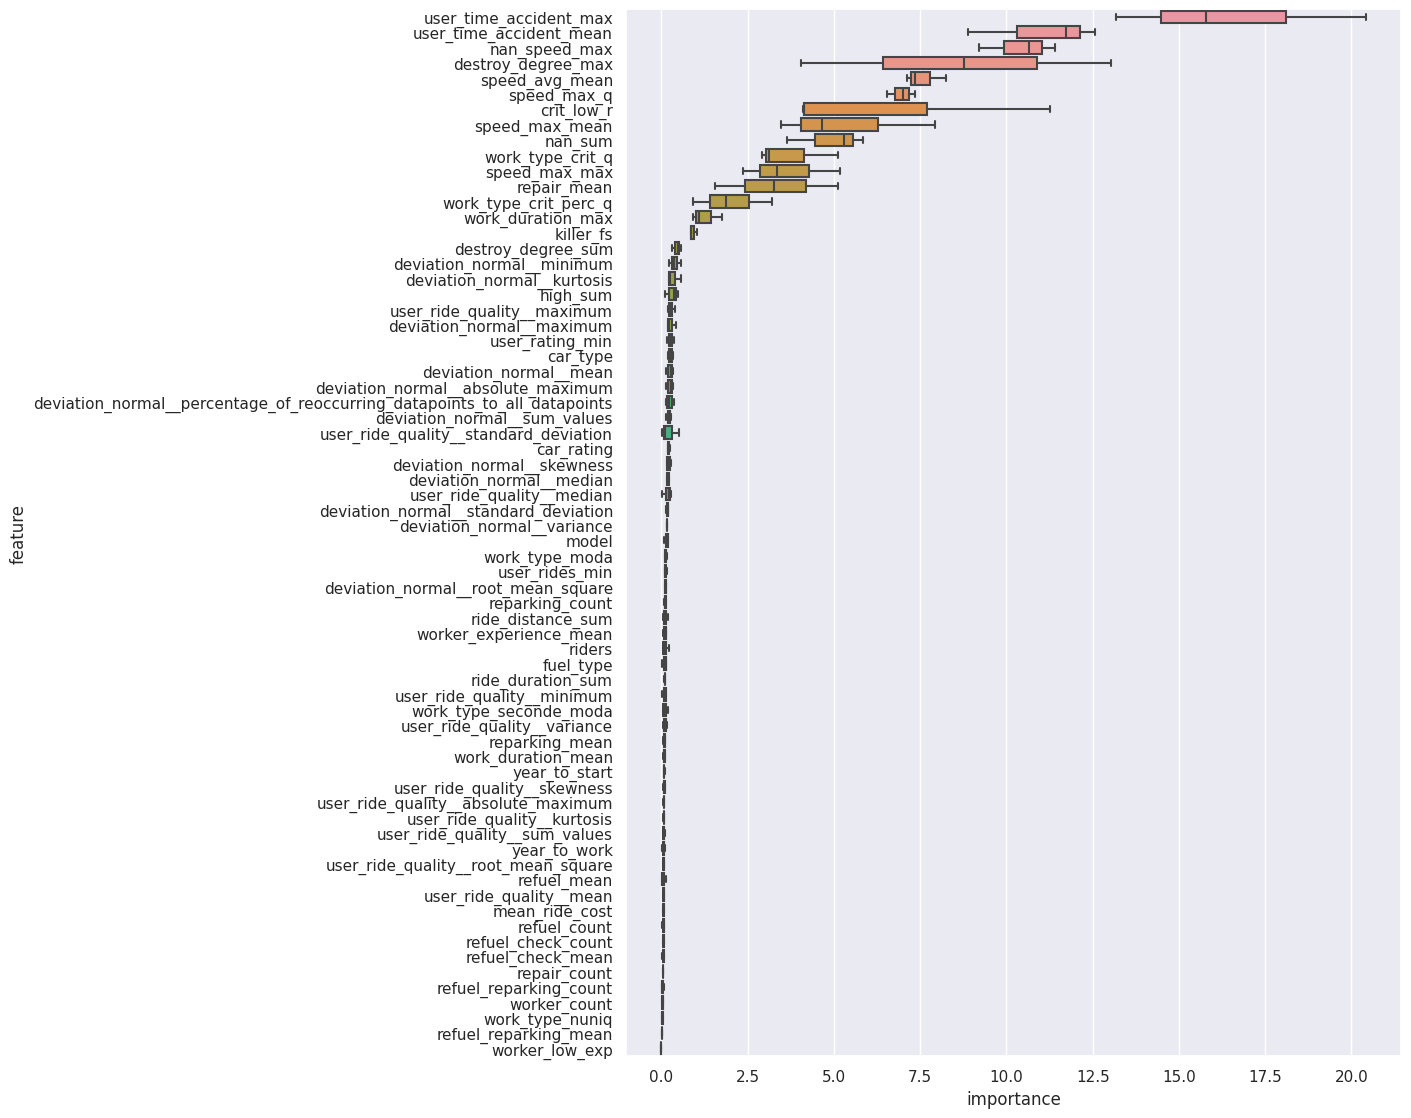

In [104]:
def plot_importance(df, best_model, height, top_n=50):
    
    fi = pd.DataFrame(index = df.columns, columns = [])
    for i, m in enumerate(best_model):
        fi[f'm_{i}'] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:,[0, 2]]#.to_frame()
    fi.columns = ['feature','importance']

    cols_ord = list(fi.groupby('feature')['importance'].mean().sort_values(ascending=False).index)
    print('Всего признаков {} Усреднее по {}-ти моделям: '.format(len(cols_ord), len(best_model)) )
    cols_ord = cols_ord[:top_n]
    
    fi = fi[fi['feature'].isin(cols_ord)]
    
    plt.figure(figsize=(10, len(cols_ord)*height))
    b = sns.boxplot(data=fi, y='feature', x='importance', orient='h', order=cols_ord)
    
    print('На график нанесено топ-{} признаков'.format(top_n))
    return fi.groupby(by =['feature'], as_index=False)['importance'].mean().sort_values(by='importance', ascending=False)

df_feats_imp = plot_importance(car_info_fs[filtered_features].drop(targets, axis=1, errors='ignore'), clfs[-
                                                                                                           3:], 0.20, top_n=100)


In [105]:
!pip install catboost -q
!pip uninstall opencv-python -y -q
!pip install opencv-python -q

^C
ERROR: Operation cancelled by user


Process ForkPoolWorker-9:
Process ForkPoolWorker-10:
Process ForkPoolWorker-12:
Process ForkPoolWorker-11:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "

In [106]:
!pip install shap -q

Process ForkPoolWorker-14:
Process ForkPoolWorker-13:
Process ForkPoolWorker-15:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/conda/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 10

In [107]:
# import catboost
# from catboost import *

import shap

shap.initjs()

ModuleNotFoundError: No module named 'shap'

In [ ]:
explainer = shap.TreeExplainer(clfs[-1])


train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
shap_values = explainer.shap_values(train_dataset)
# shap_values

# shap.dependence_plot("RM", shap_values, X)

shap.summary_plot(shap_values, X_train, max_display = 25)

In [ ]:
from catboost.utils import get_confusion_matrix
import seaborn
# from sklearn.metrics import confusion_matrix


train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
confusion_matrix = get_confusion_matrix(clf, train_dataset, thread_count=-1)

In [ ]:
target_dict  = {'engine_ignition' : 0,
    'another_bug' : 1,
    'engine_overheat' : 2,
    'gear_stick' : 3,
    'engine_fuel' : 4,
    'engine_check' : 5,
    'break_bug' : 6,
    'wheel_shake' : 7,
    'electro_bug' : 8}

# target_dict = {v:k for k, v in target_dict.items()}

f = lambda x: target_dict.get(x, x)

# car_info_fs['target_2'] = car_info_fs['target_2'].apply(f)

y_test['target_2'] = y_test['target_2'].apply(f)
y_test.value_counts()

In [ ]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# cm = confusion_matrix(y_test, cbc_pred, normalize='all')
# cmd = ConfusionMatrixDisplay(cm, display_labels=target_dict.keys())
# cmd.plot(xticks_rotation='45', cmap = 'viridis_r');


In [ ]:
!pip install pandas_ml >> None

In [ ]:
# from pandas_ml import ConfusionMatrix
# import matplotlib.pyplot as plt

# cm = ConfusionMatrix(y_test, y_pred)
# cmd.plot()

In [ ]:
y_test['target_2'].value_counts()

# Catboost Regressor

In [ ]:
# print(huge_train_final.columns)
# huge_train_final = huge_train_final

random_state = 42
n_splits = 3 # kfolds
print('num folds', n_splits)
clfs = []

targets = ['target_2']
X = car_info_fs[filtered_features].drop(targets, axis=1, errors='ignore')#.copy()
y = car_info_fs[targets]#.copy()

# параметры валидации, обучение будет идти на 6 X n_splits фолдах

kFold_random_state = [42]# , 666, 228, 777, 2021, 75]
N = len(kFold_random_state)*n_splits

kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

best_fs = ['ride_distance_sum','destroy_degree_sum','destroy_degree_max','riders','worker_experience_mean',
    'worker_low_exp','work_duration_mean','destroy_degree_max','work_type_crit_q','killer_fs',
    'repair_count','refuel_check_count','repair_mean','repair_mean','work_duration_max',
    'work_type_nuniq','user_time_accident_max','user_rating_min','user_rides_min']

# # Тренд взависимости от Таргета
# C = 1 # (2 - x.real_slope)*(2 + (x['deviation_normal__linear_trend__attr_"slope"'])**2)
ignored_features = ['car_rating', 'main_city', 'riders']
ignored_features_dict = {}
for num_i, fs in enumerate(best_fs):
    ignored_features+=[fs]
    scores = []
    for train_index, test_index in kf.split(X):

        # X_train, X_test = X[X.kfold!=kfold].drop('kfold', axis=1), X[X.kfold==kfold].drop('kfold', axis=1)
        # y_train, y_test = y[y.kfold!=kfold].drop('kfold', axis=1), y[y.kfold==kfold].drop('kfold', axis=1)

        X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
        eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)

        print(X_train.shape, y_train.shape)
        clf = CatBoostRegressor(iterations = 30_000,
                              loss_function = 'MAE',
                              eval_metric = 'MAPE', #'AUC:hints=skip_train~false',
    #                           class_names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                              cat_features = cat_features,
                              random_seed=42,                          
    #                           'learning_rate': 0.05953207713558619,
                              colsample_bylevel =  0.09874152157026818,
                              subsample = 0.9563761143682146,
    #                           l2_leaf_reg = 9.178962968420354,
                              min_data_in_leaf = 243,
                              max_bin = 187,
                              ignored_features = ignored_features,
                              task_type='CPU', #auto_class_weights = 'SqrtBalanced',
                              early_stopping_rounds=100)# + kfold*10 )


        clfs.append(clf)

        # clf.fit(X_train, y_train, eval_set=(X_test, y_test),
        clf.fit(train_dataset, eval_set=eval_dataset,
                verbose = False, use_best_model = True, plot = False)
        scores.append(clf.best_score_['validation']['MAPE'])
        # scores.append(np.mean([v for k, v in clfs[0].best_score_['validation'].items() if 'Recall' in k]))
        print('score', scores[-1])
    
    print('------------', np.mean(scores))
    ignored_features_dict[num_i] = np.mean(scores)
    
#     clf.save_model("./tmp_data/cool_catboost_model_kfold_{}".format(hash(train_index)))
        
        
# assert len(clfs) == N

# массив для записи финального результата
# y_pred = np.zeros((test_data.shape[0], 10))
scores = []
for n, clf in enumerate(clfs):
    # y_pred += clf.predict_proba(test_data[filtered_features])#[:,1]
    scores.append(clf.best_score_['validation']['MAPE'])
#     clf.save_model("./tmp_data/cool_catboost_model_{}_deep".format(n))

# y_pred /= N
print('mean MultiLogloss', np.mean(scores))

In [ ]:
# [v for k, v in clfs[0].best_score_['validation'].items() if 'Recall' in k]
clfs[0].best_score_['validation']

# Catboost Regressor

In [ ]:
# # print(huge_train_final.columns)
# # huge_train_final = huge_train_final

# random_state = 42
# n_splits = 3 # kfolds
# print('n_fold', n_splits)
# clfs = []

# targets = targets

# X = car_info_fs[filtered_features].fillna(0)#.copy()
# y = car_info_fs[['target_1']].fillna(car_info_fs['target_1'].mean())#.copy()

# # параметры валидации, обучение будет идти на 6 X n_splits фолдах

# kFold_random_state = [42]# , 666, 228, 777, 2021, 75]
# N = len(kFold_random_state)*n_splits

# kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# for train_index, test_index in kf.split(X):
        
# #     X_train, X_test = X[X.kfold!=kfold].drop('kfold', axis=1), X[X.kfold==kfold].drop('kfold', axis=1)
# #     y_train, y_test = y[y.kfold!=kfold].drop('kfold', axis=1), y[y.kfold==kfold].drop('kfold', axis=1)

#     X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
# #     train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
# #     eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
    
#     print(X_train.shape, y_train.shape)
#     clf = CatBoostRegressor(iterations = 30_000,
#                           loss_function = 'MAE',
#                           eval_metric = 'MAPE', #'AUC:hints=skip_train~false',
# #                           class_names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
#                           cat_features = cat_features,
#                           random_seed=42,                          
# #                           'learning_rate': 0.05953207713558619,
#                           colsample_bylevel =  0.09874152157026818,
#                           subsample = 0.9563761143682146,
# #                           l2_leaf_reg = 9.178962968420354,
#                           min_data_in_leaf = 243,
#                           max_bin = 187,
#                           task_type='CPU', #auto_class_weights = 'SqrtBalanced',
#                           early_stopping_rounds=2180)# + kfold*10 )
    
#     clfs.append(clf)

#     clf.fit(X_train, y_train, eval_set=(X_test, y_test),
# #     clf.fit(train_dataset, eval_set=eval_dataset,
#             verbose = 500, use_best_model = True, plot = False)
# #     clf.save_model("./tmp_data/cool_catboost_model_kfold_{}".format(hash(train_index)))
        
        
# assert len(clfs) == N

# # массив для записи финального результата
# # y_pred = np.zeros((test_data.shape[0], 10))
# scores = []
# for n, clf in enumerate(clfs):
#     # y_pred += clf.predict_proba(test_data[filtered_features])#[:,1]
#     scores.append(clf.best_score_['validation']['MAE'])
# #     clf.save_model("./tmp_data/cool_catboost_model_{}_deep".format(n))

# # y_pred /= N
# print('mean MAE', np.mean(scores))

In [ ]:
# clf.best_score_['validation']

# Feature Importance

In [ ]:
def plot_importance(df, best_model, height, top_n=50):
    
    fi = pd.DataFrame(index = df.columns, columns = [])
    for i, m in enumerate(best_model):
        fi[f'm_{i}'] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:,[0, 2]]#.to_frame()
    fi.columns = ['feature','importance']

    cols_ord = list(fi.groupby('feature')['importance'].mean().sort_values(ascending=False).index)
    print('Всего признаков', len(cols_ord), 'Усреднее по {}-ти моделям: '.format(len(best_model)) )
    cols_ord = cols_ord[:top_n]
    
    fi = fi[fi['feature'].isin(cols_ord)]
    
    plt.figure(figsize=(10, len(cols_ord)*height))
    b = sns.boxplot(data=fi, y='feature', x='importance', orient='h', order=cols_ord)
    
    print('На график нанесено топ-{} признаков'.format(top_n))
    return fi.groupby(by =['feature'], as_index=False)['importance'].mean().sort_values(by='importance', ascending=False)

df_feats_imp = plot_importance(car_info_fs[filtered_features], clfs[3:6], height = 0.20, top_n = 70)


In [ ]:
explainer = shap.TreeExplainer(clfs[2])


train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
shap_values = explainer.shap_values(train_dataset)
# shap_values

# shap.dependence_plot("RM", shap_values, X)

shap.summary_plot(shap_values, X_train)

In [ ]:
# plt.figure(figsize = (20, 20));
shap.dependence_plot("riders", shap_values, X_train)


# Смотрим на остатки

In [ ]:
cbr_prediction = clfs[0].predict(X_test)

df_pred = pd.DataFrame(cbr_prediction, columns = ["Predicted values"])
df_pred["Actual values"] =  y_test['target_1'].values

sns.relplot(data = df_pred, aspect = 4, kind = 'line')

In [ ]:
df_pred['diff'] = df_pred["Actual values"] - df_pred["Predicted values"]

sns.relplot(data = df_pred['diff'], aspect = 4, kind = 'line')

In [ ]:
# sns.realplot(data = X[])


# Тест на логику и гипотезы из таблицы

In [ ]:
target_dict  = {'engine_ignition' : 0,
    'another_bug' : 1,
    'engine_overheat' : 2,
    'gear_stick' : 3,
    'engine_fuel' : 4,
    'engine_check' : 5,
    'break_bug' : 6,
    'wheel_shake' : 7,
    'electro_bug' : 8}

target_dict = {v:k for k, v in target_dict.items()}

f = lambda x: target_dict.get(x, x)
car_info_fs['target_2'] = car_info_fs['target_2'].apply(f)

In [ ]:
# sns.set()
plt.figure(figsize = (20, 6))
sns.histplot(data = car_info_fs, hue = 'target_2', x = 'target_1', bins=50);

In [ ]:
sns.displot(data = car_info_fs, x = 'target_2', y = 'target_1', bins=50,
            aspect=5, height=10);

In [ ]:
car_info_fs

In [ ]:
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=n_clusters, random_state=42, max_iter=500)
cluster_labels = clusterer.fit_predict(X_embedded)

In [ ]:
Снизить разерность датасета, используя метод t-SNE

In [ ]:
from sklearn.manifold import TSNE


# Вспомогатльеные фрагменты кода
# data_x_y = TSNE(n_components=2, learning_rate='auto',
#                 random_state=22, n_jobs=-1, 
#                 init='random').fit_transform(df)

In [ ]:

#Вспомогатльеные фрагменты кода
# plt.figure(figsize=(12,9))
# plt.scatter(data_x, data_y, c=cluster_labels, cmap ='Set3', s=5)
# plt.scatter(data_x, data_y, c=y_blobs, s=1, cmap ='Set3')
# plt.legend(cluster_labels)
# plt.show()

In [ ]:
# TODO
- Догенерить базововую часть датасета
- Пошерить доступ на ноутбуки
- Гегерировать фичи уже при написании ноутбуков
- Утвердить программу 
- 

# Открываем файлы и смотрим, все ли в порядке

In [ ]:
# https://www.projectpro.io/recipes/upload-files-to-google-drive-using-python

# url = 'https://drive.google.com/file/d/1eqFIZCJTkXY-PsTeS-uz_DousIH3XQu-/view?usp=share_link'
# url = 'https://drive.google.com/file/d/1s_UlUxRszNn24R_cyfS9RWTNaJS2Z8DB/view?usp=share_link'
# url = 'https://drive.google.com/file/d/1eqFIZCJTkXY-PsTeS-uz_DousIH3XQu-/view?usp=share_link'
# url ='https://drive.google.com/uc?id=' + url.split('/')[-2]

url = 'https://drive.google.com/uc?id=1s_UlUxRszNn24R_cyfS9RWTNaJS2Z8DB'  # rides_info
rides_info = pd.read_csv(url)
rides_info.head().columns

# url = 'https://drive.google.com/uc?id=1eqFIZCJTkXY-PsTeS-uz_DousIH3XQu-'  # car_info
# car_info = pd.read_csv(url)
# car_info.head()

In [ ]:
import pandas as pd

# url = 'https://drive.google.com/file/d/1cGrFMilJtLrPPOTRfH46DX3qvBRnxdUT/view?usp=sharing'
# url ='https://drive.google.com/uc?id=' + url.split('/')[-2]
# url = 'https://drive.google.com/uc?id=1FkwxNT8_vN2pIYoFJx29l4ZhDYBzMamt' # rider_info - информация про водителей
# rider_info = pd.read_csv(url)
# rider_info.head()


In [ ]:
cols = ['car_id', 'model', 'car_type', 'fuel_type', 'car_rating', 'year_to_start', 'main_city', 'riders', 'year_to_work', 'target_1', 'target_2']
url = 'https://drive.google.com/uc?id=1s_UlUxRszNn24R_cyfS9RWTNaJS2Z8DB'
car_info = pd.read_csv(url)   # car_info - информация про машины с таргетом
car_info[cols]['target_2'].nunique()

In [ ]:
url = 'https://drive.google.com/uc?id=1eqFIZCJTkXY-PsTeS-uz_DousIH3XQu-'  
rides_info = pd.read_csv(url) # rides_info - информация про поездки
rides_info.drop(['car_rating','killer_fs'], axis=1).head(3)

In [ ]:
cols = ['user_id', 'age', 'sex', 'user_rating', 'user_rides', 'user_time_accident', 'first_ride_date']
url = 'https://drive.google.com/uc?id=1FkwxNT8_vN2pIYoFJx29l4ZhDYBzMamt' 
driver_info = pd.read_csv(url)  # driver_info - информация про водителей
driver_info[cols].head(3)

In [ ]:
cols = ['worker_id', 'car_id', 'work_type', 'destroy_degree', 'work_duration', 'fix_date']
url = 'https://drive.google.com/uc?id=1_UeE8KZmLb50phMoxcVT2hIdzToyVr42' # fix_info - информация про ремонт машин
fix_info = pd.read_csv(url)
fix_info[cols].head(3)

In [ ]:
# !pip install pydrive

In [ ]:
# gauth = GoogleAuth()           
# drive = GoogleDrive(gauth)  

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

gauth = GoogleAuth()           
drive = GoogleDrive(gauth) # 1hqEuNuaYdXV9D-j_Ctx0TndExJwoc23b

In [ ]:
upload_file_list = ['../data/fix_info.csv']
for upload_file in upload_file_list:
	gfile = drive.CreateFile({'parents': [{'id': '1hqEuNuaYdXV9D-j_Ctx0TndExJwoc23b'}]})
	# Read file and set it as the content of this instance.
	gfile.SetContentFile(upload_file)
	gfile.Upload() # Upload the file.

In [ ]:
!ls ../data/

In [ ]:
!conda install pycaret

In [ ]:
from pycaret.utils import version
version()